In [1]:
# Import necessary library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import make_scorer, mean_squared_error
from xgboost import XGBRegressor

# Data Merging

In [3]:
# Loading all relevant data for analysis
weat = pd.read_csv(r"Raw Data\dataset\Weather.csv")
solar = pd.read_excel(r"Raw Data\dataset\solar-irradiance\Solar Irradiance 2014-2017.xlsx")
train = pd.read_csv(r"Raw Data\dataset\train.csv")

In [4]:
# Identifying the common column to be used as the base for merging datasets
print('Weather data columns:', weat.columns.to_list(), '\n')
print('Solar Irradiance data columns:', solar.columns.to_list(), '\n')
print('Train data columns:', train.columns.to_list())

Weather data columns: ['date_time', 'maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour', 'uvIndex', 'moon_illumination', 'moonrise', 'moonset', 'sunrise', 'sunset', 'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC', 'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure', 'tempC', 'visibility', 'winddirDegree', 'windspeedKmph'] 

Solar Irradiance data columns: ['Year', 'Month', 'Day', 'Hour', 'Minute', 'DHI', 'DNI', 'GHI', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Cloud Type', 'Dew Point', 'Solar Zenith Angle', 'Surface Albedo', 'Wind Speed', 'Relative Humidity', 'Temperature', 'Pressure'] 

Train data columns: ['Timestamp', '% Baseline']


In [5]:
# The Timestamp-related column appears to be a suitable base for merging the datasets
print('Weather Timestamp:\n', weat['date_time'], '\n')
print('Solar Irradiance Timestamp:\n', solar[['Year', 'Month', 'Day', 'Hour', 'Minute']], '\n')
print('Train Timestamp:\n', train['Timestamp'])

Weather Timestamp:
 0           1/1/2014 0:00
1           1/1/2014 1:00
2           1/1/2014 2:00
3           1/1/2014 3:00
4           1/1/2014 4:00
               ...       
35059    12/31/2017 19:00
35060    12/31/2017 20:00
35061    12/31/2017 21:00
35062    12/31/2017 22:00
35063    12/31/2017 23:00
Name: date_time, Length: 35064, dtype: object 

Solar Irradiance Timestamp:
        Year  Month  Day  Hour  Minute
0      2014      1    1     0       0
1      2014      1    1     1       0
2      2014      1    1     2       0
3      2014      1    1     3       0
4      2014      1    1     4       0
...     ...    ...  ...   ...     ...
35059  2017     12   31    19       0
35060  2017     12   31    20       0
35061  2017     12   31    21       0
35062  2017     12   31    22       0
35063  2017     12   31    23       0

[35064 rows x 5 columns] 

Train Timestamp:
 0         Jan 1, 2014 7am
1         Jan 1, 2014 8am
2         Jan 1, 2014 9am
3        Jan 1, 2014 10am
4        Ja

In [6]:
# Converting timestamp-related columns to datetime format for consistency in merging
weat['Timestamp'] = pd.to_datetime(weat['date_time'])
weat = weat.drop(columns='date_time')
solar['Timestamp'] = pd.to_datetime(solar[['Year', 'Month', 'Day', 'Hour', 'Minute']])
solar = solar.drop(columns=['Year', 'Month', 'Day', 'Hour', 'Minute'])
train['Timestamp'] = pd.to_datetime(train['Timestamp'], format='%b %d, %Y %I%p')

In [7]:
# Print out result as prove of successful conversion
print('Weather Timestamp:\n', weat['Timestamp'], '\n')
print('Solar Irradiance Timestamp:\n', solar['Timestamp'], '\n')
print('Train Timestamp:\n', train['Timestamp'])

Weather Timestamp:
 0       2014-01-01 00:00:00
1       2014-01-01 01:00:00
2       2014-01-01 02:00:00
3       2014-01-01 03:00:00
4       2014-01-01 04:00:00
                ...        
35059   2017-12-31 19:00:00
35060   2017-12-31 20:00:00
35061   2017-12-31 21:00:00
35062   2017-12-31 22:00:00
35063   2017-12-31 23:00:00
Name: Timestamp, Length: 35064, dtype: datetime64[ns] 

Solar Irradiance Timestamp:
 0       2014-01-01 00:00:00
1       2014-01-01 01:00:00
2       2014-01-01 02:00:00
3       2014-01-01 03:00:00
4       2014-01-01 04:00:00
                ...        
35059   2017-12-31 19:00:00
35060   2017-12-31 20:00:00
35061   2017-12-31 21:00:00
35062   2017-12-31 22:00:00
35063   2017-12-31 23:00:00
Name: Timestamp, Length: 35064, dtype: datetime64[ns] 

Train Timestamp:
 0       2014-01-01 07:00:00
1       2014-01-01 08:00:00
2       2014-01-01 09:00:00
3       2014-01-01 10:00:00
4       2014-01-01 11:00:00
                ...        
18937   2017-09-30 14:00:00
18938   2

Based on length alone, the timestamps in the train data do not match those in the solar irradiance and weather data. Further verification is required to avoid errors during merging.

In [8]:
# 1. Check for mismatched and duplicate timestamps between solar and weat

# Find timestamps in weat that are not in solar
mismatched_weat_solar = weat[~weat['Timestamp'].isin(solar['Timestamp'])]['Timestamp'].unique()
print("Timestamps in weather data not found in solar data:", mismatched_weat_solar)

# Find timestamps in solar that are not in weat
mismatched_solar_weat = solar[~solar['Timestamp'].isin(weat['Timestamp'])]['Timestamp'].unique()
print("Timestamps in solar data not found in weather data:", mismatched_solar_weat)

# Check for duplicate timestamps in weat
duplicate_weat = weat[weat['Timestamp'].duplicated(keep=False)]['Timestamp'].unique()
print("Duplicate timestamps in weather data:", duplicate_weat)

# Check for duplicate timestamps in solar
duplicate_solar = solar[solar['Timestamp'].duplicated(keep=False)]['Timestamp'].unique()
print("Duplicate timestamps in solar data:", duplicate_solar)

# 2. Check for duplicate timestamps in train

duplicate_train = train[train['Timestamp'].duplicated(keep=False)]['Timestamp'].unique()
print("Duplicate timestamps in train data:", duplicate_train)

Timestamps in weather data not found in solar data: <DatetimeArray>
[]
Length: 0, dtype: datetime64[ns]
Timestamps in solar data not found in weather data: <DatetimeArray>
[]
Length: 0, dtype: datetime64[ns]
Duplicate timestamps in weather data: <DatetimeArray>
[]
Length: 0, dtype: datetime64[ns]
Duplicate timestamps in solar data: <DatetimeArray>
[]
Length: 0, dtype: datetime64[ns]
Duplicate timestamps in train data: <DatetimeArray>
[]
Length: 0, dtype: datetime64[ns]


Since the timestamps in weat and solar are identical, these datasets can be merged directly. Afterward, merge the result with train using a left join, as the timestamps in train do not fully match those in the weather and solar irradiance data.

In [9]:
# Merging datasets
merged_df = pd.merge(weat, solar, on='Timestamp')
merged_df = pd.merge(merged_df, train, on='Timestamp', how='left')

# Move the 'Timestamp' column to the first position
merged_df = merged_df[['Timestamp'] + [col for col in merged_df.columns if col not in ['Timestamp']]]
print(merged_df.head())

            Timestamp  maxtempC  mintempC  totalSnow_cm  sunHour  uvIndex  \
0 2014-01-01 00:00:00        -3        -6           0.0      8.7        2   
1 2014-01-01 01:00:00        -3        -6           0.0      8.7        2   
2 2014-01-01 02:00:00        -3        -6           0.0      8.7        2   
3 2014-01-01 03:00:00        -3        -6           0.0      8.7        2   
4 2014-01-01 04:00:00        -3        -6           0.0      8.7        2   

   moon_illumination moonrise  moonset  sunrise  ... Clearsky GHI  \
0                  1  6:58 AM  5:05 PM  7:12 AM  ...          0.0   
1                  1  6:58 AM  5:05 PM  7:12 AM  ...          0.0   
2                  1  6:58 AM  5:05 PM  7:12 AM  ...          0.0   
3                  1  6:58 AM  5:05 PM  7:12 AM  ...          0.0   
4                  1  6:58 AM  5:05 PM  7:12 AM  ...          0.0   

       Cloud Type  Dew Point  Solar Zenith Angle  Surface Albedo  Wind Speed  \
0  Probably Clear         -6              

In [10]:
print(merged_df.columns)

Index(['Timestamp', 'maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour',
       'uvIndex', 'moon_illumination', 'moonrise', 'moonset', 'sunrise',
       'sunset', 'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC',
       'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure',
       'tempC', 'visibility', 'winddirDegree', 'windspeedKmph', 'DHI', 'DNI',
       'GHI', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Cloud Type',
       'Dew Point', 'Solar Zenith Angle', 'Surface Albedo', 'Wind Speed',
       'Relative Humidity', 'Temperature', 'Pressure', '% Baseline'],
      dtype='object')


In [11]:
print(merged_df.head())

            Timestamp  maxtempC  mintempC  totalSnow_cm  sunHour  uvIndex  \
0 2014-01-01 00:00:00        -3        -6           0.0      8.7        2   
1 2014-01-01 01:00:00        -3        -6           0.0      8.7        2   
2 2014-01-01 02:00:00        -3        -6           0.0      8.7        2   
3 2014-01-01 03:00:00        -3        -6           0.0      8.7        2   
4 2014-01-01 04:00:00        -3        -6           0.0      8.7        2   

   moon_illumination moonrise  moonset  sunrise  ... Clearsky GHI  \
0                  1  6:58 AM  5:05 PM  7:12 AM  ...          0.0   
1                  1  6:58 AM  5:05 PM  7:12 AM  ...          0.0   
2                  1  6:58 AM  5:05 PM  7:12 AM  ...          0.0   
3                  1  6:58 AM  5:05 PM  7:12 AM  ...          0.0   
4                  1  6:58 AM  5:05 PM  7:12 AM  ...          0.0   

       Cloud Type  Dew Point  Solar Zenith Angle  Surface Albedo  Wind Speed  \
0  Probably Clear         -6              

In [12]:
test = pd.read_csv(r"Raw Data\dataset\test.csv")
print(test)

              Timestamp  % Baseline
0       Oct 1, 2017 6am         NaN
1       Oct 1, 2017 7am         NaN
2       Oct 1, 2017 8am         NaN
3       Oct 1, 2017 9am         NaN
4      Oct 1, 2017 10am         NaN
...                 ...         ...
1072  Dec 31, 2017 12pm         NaN
1073   Dec 31, 2017 1pm         NaN
1074   Dec 31, 2017 2pm         NaN
1075   Dec 31, 2017 3pm         NaN
1076   Dec 31, 2017 4pm         NaN

[1077 rows x 2 columns]


In [13]:
# Ensure that the Timestamp column is in datetime format
merged_df['Timestamp'] = pd.to_datetime(merged_df['Timestamp'])

# Define the split date
split_date = '2017-10-01'

# Create the train and test datasets
train_df = merged_df[merged_df['Timestamp'] < split_date]
test_df = merged_df[merged_df['Timestamp'] >= split_date]

# Optional: Reset indices if needed
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [14]:
print(train_df['Timestamp'], '\n')
print(test_df['Timestamp'])

0       2014-01-01 00:00:00
1       2014-01-01 01:00:00
2       2014-01-01 02:00:00
3       2014-01-01 03:00:00
4       2014-01-01 04:00:00
                ...        
32851   2017-09-30 19:00:00
32852   2017-09-30 20:00:00
32853   2017-09-30 21:00:00
32854   2017-09-30 22:00:00
32855   2017-09-30 23:00:00
Name: Timestamp, Length: 32856, dtype: datetime64[ns] 

0      2017-10-01 00:00:00
1      2017-10-01 01:00:00
2      2017-10-01 02:00:00
3      2017-10-01 03:00:00
4      2017-10-01 04:00:00
               ...        
2203   2017-12-31 19:00:00
2204   2017-12-31 20:00:00
2205   2017-12-31 21:00:00
2206   2017-12-31 22:00:00
2207   2017-12-31 23:00:00
Name: Timestamp, Length: 2208, dtype: datetime64[ns]


In [15]:
# Checking existence of missing data
print(train_df.isnull().sum()[train_df.isnull().sum() > 0])
print(test_df.isnull().sum()[test_df.isnull().sum() > 0])

DHI              2435
DNI              2435
GHI              2435
Clearsky DHI     2435
Clearsky DNI     2435
Clearsky GHI     2435
Cloud Type       2250
% Baseline      13914
dtype: int64
DHI              342
DNI              342
GHI              342
Clearsky DHI     342
Clearsky DNI     342
Clearsky GHI     342
Cloud Type       236
% Baseline      2208
dtype: int64


In [16]:
train_df.to_excel(r"Processed Data\train_merged.xlsx", index=False)
test_df.to_excel(r"Processed Data\test_merged.xlsx", index=False)

# Data Cleaning

## Handling Missing Data

In [17]:
# Read merged data
data = pd.read_excel(r"Processed Data\train_merged.xlsx")
test = pd.read_excel(r"Processed Data\test_merged.xlsx")

In [18]:
print(data.columns)
print(test.columns)

Index(['Timestamp', 'maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour',
       'uvIndex', 'moon_illumination', 'moonrise', 'moonset', 'sunrise',
       'sunset', 'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC',
       'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure',
       'tempC', 'visibility', 'winddirDegree', 'windspeedKmph', 'DHI', 'DNI',
       'GHI', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Cloud Type',
       'Dew Point', 'Solar Zenith Angle', 'Surface Albedo', 'Wind Speed',
       'Relative Humidity', 'Temperature', 'Pressure', '% Baseline'],
      dtype='object')
Index(['Timestamp', 'maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour',
       'uvIndex', 'moon_illumination', 'moonrise', 'moonset', 'sunrise',
       'sunset', 'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC',
       'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure',
       'tempC', 'visibility', 'winddirDegree', 'windspeedKmph', 'DHI', 'DNI',
       'GHI', 'Clearsky 

In [19]:
# Checking existence of missing data
missing_data = data.isnull().sum()
columns_with_missing = missing_data[missing_data > 0]
print(columns_with_missing)

# Checking existence of missing data
missing_data = test.isnull().sum()
columns_with_missing = missing_data[missing_data > 0]
print(columns_with_missing)

DHI              2435
DNI              2435
GHI              2435
Clearsky DHI     2435
Clearsky DNI     2435
Clearsky GHI     2435
Cloud Type       2250
% Baseline      13914
dtype: int64
DHI              342
DNI              342
GHI              342
Clearsky DHI     342
Clearsky DNI     342
Clearsky GHI     342
Cloud Type       236
% Baseline      2208
dtype: int64


### Dealing with missing data on DHI and DNI and each of their clearsky version value since they have similar characteristics (context-wise from metadata). GHI is being excluded since it can be calculated by using the value of DHI, DNI, and 'Solar Zenith Angle'

In [20]:
columns = ['DHI', 'DNI', 'GHI', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Solar Zenith Angle']
print(data[columns])

        DHI  DNI   GHI  Clearsky DHI  Clearsky DNI  Clearsky GHI  \
0       0.0  0.0   0.0           0.0           0.0           0.0   
1       0.0  0.0   0.0           0.0           0.0           0.0   
2       0.0  0.0   0.0           0.0           0.0           0.0   
3       0.0  0.0   0.0           0.0           0.0           0.0   
4       0.0  0.0   0.0           0.0           0.0           0.0   
...     ...  ...   ...           ...           ...           ...   
32851  25.0  0.0  25.0          99.0         741.0         466.0   
32852   NaN  NaN   NaN           NaN           NaN           NaN   
32853   NaN  NaN   NaN           NaN           NaN           NaN   
32854   0.0  0.0   0.0           0.0           0.0           0.0   
32855   0.0  0.0   0.0           0.0           0.0           0.0   

       Solar Zenith Angle  
0                  124.02  
1                  135.09  
2                  145.77  
3                  155.07  
4                  160.55  
...            

Verifying the Accuracy of GHI Calculation

**Formula: GHI = DNI * cos('Solar Zenith Angle') + DHI**

In [21]:
# Drop rows with any NaN values in the relevant columns
clean_data = data.dropna(subset=['DNI', 'DHI', 'Solar Zenith Angle', 'GHI']).copy()

# Calculate GHI using the given formula directly with Solar Zenith Angle in degrees
calculated_GHI = clean_data['DNI'] * np.cos(np.deg2rad(clean_data['Solar Zenith Angle'])) + clean_data['DHI']

# Compare the calculated GHI with the actual GHI in the data
clean_data.loc[:, 'GHI Correct'] = np.isclose(calculated_GHI, clean_data['GHI'], rtol=5e-1, atol=5e-1)

# Display rows where the GHI calculation does not match
incorrect_ghi = clean_data[~clean_data['GHI Correct']]

print(f"Number of incorrect GHI calculations: {len(incorrect_ghi)}")
print("Rows with incorrect GHI calculations:")
print(incorrect_ghi[['DNI', 'DHI', 'Solar Zenith Angle', 'GHI', 'GHI Correct']])

Number of incorrect GHI calculations: 0
Rows with incorrect GHI calculations:
Empty DataFrame
Columns: [DNI, DHI, Solar Zenith Angle, GHI, GHI Correct]
Index: []


Verifying the Accuracy of Clearsky GHI Calculation

**Formula: Clearsky GHI = Clearsky DNI * cos('Solar Zenith Angle') + Clearsky DHI**

In [22]:
# Drop rows with any NaN values in the relevant columns
clean_data2 = data.dropna(subset=['Clearsky DNI', 'Clearsky DHI', 'Solar Zenith Angle', 'Clearsky GHI']).copy()

# Calculate Clearsky GHI using the given formula directly with Solar Zenith Angle in degrees
calculated_clear_GHI = clean_data2['Clearsky DNI'] * np.cos(np.deg2rad(clean_data2['Solar Zenith Angle'])) + clean_data2['Clearsky DHI']

# Compare the calculated Clearsky GHI with the actual Clearsky GHI in the data
clean_data2.loc[:, 'Clearsky GHI Correct'] = np.isclose(calculated_clear_GHI, clean_data2['Clearsky GHI'], rtol=5e-1, atol=5e-1)

# Display rows where the Clearsky GHI calculation does not match
incorrect_clear_ghi = clean_data2[~clean_data2['Clearsky GHI Correct']]

print(f"Number of incorrect Clearsky GHI calculations: {len(incorrect_clear_ghi)}")
print("Rows with incorrect Clearsky GHI calculations:")
print(incorrect_clear_ghi[['Clearsky DNI', 'Clearsky DHI', 'Solar Zenith Angle', 'Clearsky GHI', 'Clearsky GHI Correct']])

Number of incorrect Clearsky GHI calculations: 0
Rows with incorrect Clearsky GHI calculations:
Empty DataFrame
Columns: [Clearsky DNI, Clearsky DHI, Solar Zenith Angle, Clearsky GHI, Clearsky GHI Correct]
Index: []


With the GHI formula confirmed as accurate, the next step is to address the missing data in the 'DHI', 'DNI', 'Clearsky DHI', and 'Clearsky DNI' columns, as GHI can be derived from these columns along with the Solar Zenith Angle.

In addition to missing values, there are also many instances where all values in a row are zero. The next step is to count the number of zero values and missing values for each column.

In [23]:
columns = ['DHI', 'DNI', 'Clearsky DHI', 'Clearsky DNI']
# Count the number of 0 values for each column
zero_counts = data[columns].apply(lambda x: (x == 0.00).sum())

# Count the number of null (NaN) values for each column
missing_counts = data[columns].isnull().sum()

print("Count of 0 values per column:\n", zero_counts)
print("\nCount of missing values per column:\n", missing_counts)

Count of 0 values per column:
 DHI             16274
DNI             18090
Clearsky DHI    16274
Clearsky DNI    16275
dtype: int64

Count of missing values per column:
 DHI             2435
DNI             2435
Clearsky DHI    2435
Clearsky DNI    2435
dtype: int64


Verify that within a single row, there are no instances where one column contains a 0 while another column in the same row contains a missing (NaN) value. This check helps determine whether 0 values and missing values should be treated similarly or differently.

In [24]:
conditions = []

# Loop over the columns to generate conditions
for col1 in columns:
    # Condition where col1 is 0 and other columns are NaN
    zero_with_null = (data[col1] == 0.00) & data[[col for col in columns if col != col1]].isna().any(axis=1)
    # Condition where col1 is NaN and other columns are 0
    null_with_zero = data[col1].isna() & data[[col for col in columns if col != col1]].eq(0.00).any(axis=1)
    
    # Combine the conditions for the column
    conditions.append(zero_with_null | null_with_zero)

# Combine all conditions using the OR operator to find if any row meets any of the conditions
final_condition = pd.concat(conditions, axis=1).any(axis=1)

# Check if any such row exists and print the timestamps
if final_condition.any():
    print(data.loc[final_condition, 'Timestamp'])
else:
    print("No such instance found.")

No such instance found.


Since no such instances were found, there is reduced concern regarding inconsistencies related to missing data.

**Going forward, any row where all values in the 'DHI', 'DNI', 'Clearsky DHI', and 'Clearsky DNI' columns are zero will be referred to as an invalid row, while rows where at least one of these columns has a non-zero value will be referred to as valid rows.**

Verify that if any column in a row contains a missing (NaN) or 0 value, all other specified columns in that row also contain missing (NaN) or 0 values. This check ensures there are no meaningful (non-zero, non-missing) values in other columns when one is missing or zero.

In [25]:
# Condition 1: Check for rows where any column is 0, but others have valid values
zero_condition = data[columns].apply(lambda row: any(row == 0.00) and any((row != 0.00) & (row.notna())), axis=1)

# Condition 2: Check for rows where any column is NaN, but others have valid values
nan_condition = data[columns].apply(lambda row: any(row.isna()) and any((row != 0.00) & (row.notna())), axis=1)

# Find rows that meet each condition
zero_inconsistent_rows = data[zero_condition]
nan_inconsistent_rows = data[nan_condition]

# Insert 'Timestamp' at the beginning of the columns list for printing
columns.insert(0, 'Timestamp')

# Print the rows that meet the zero_condition
print("Rows where one column is 0 and others have valid values:")
print(zero_inconsistent_rows[columns])

# Print the rows that meet the nan_condition
print("\nRows where one column is NaN and others have valid values:")
print(nan_inconsistent_rows[columns])

columns.remove('Timestamp')

Rows where one column is 0 and others have valid values:
                Timestamp    DHI  DNI  Clearsky DHI  Clearsky DNI
39    2014-01-02 15:00:00   48.0  0.0         162.0         539.0
61    2014-01-03 13:00:00   25.0  0.0          75.0         423.0
133   2014-01-06 13:00:00   27.0  0.0          56.0         489.0
134   2014-01-06 14:00:00  106.0  0.0          82.0         636.0
135   2014-01-06 15:00:00  115.0  0.0         102.0         686.0
...                   ...    ...  ...           ...           ...
32847 2017-09-30 15:00:00   19.0  0.0         149.0         760.0
32848 2017-09-30 16:00:00  111.0  0.0         144.0         789.0
32849 2017-09-30 17:00:00  113.0  0.0         129.0         804.0
32850 2017-09-30 18:00:00   95.0  0.0         112.0         796.0
32851 2017-09-30 19:00:00   25.0  0.0          99.0         741.0

[1816 rows x 5 columns]

Rows where one column is NaN and others have valid values:
Empty DataFrame
Columns: [Timestamp, DHI, DNI, Clearsky DHI, Clear

There are no missing values within valid rows, but there are instances where a valid row contains 0 values. The next step is to count the frequency of 0 values in each column.

In [26]:
zero_counts = zero_inconsistent_rows[columns].apply(lambda col: (col == 0.00).sum())

print("Frequency of 0 values in each column:")
print(zero_counts)

Frequency of 0 values in each column:
DHI                0
DNI             1816
Clearsky DHI       0
Clearsky DNI       1
dtype: int64


The only columns that contain zero values are 'DNI' and 'Clearsky DNI'. These zero values can be considered valid, as DNI measurements are not always present, even when DHI is detected.

Determine the rows that are considered valid, meaning they are not entirely 0 or entirely missing across all columns.

In [27]:
# Create a condition that checks if at least one column is neither 0 nor NaN
condition = data[columns].apply(lambda x: (x.notna() & (x != 0.00)).any(), axis=1)

# Filter the rows based on this condition
filtered_data = data[condition]

columns.insert(0, 'Timestamp')

# Print all the rows, including those with 0 or NaN values, but ensuring there's at least one valid value
print(len(filtered_data))
print(filtered_data[columns].sort_values(by='Timestamp', ascending=True))

14147
                Timestamp    DHI    DNI  Clearsky DHI  Clearsky DNI
12    2014-01-01 12:00:00   15.0  232.0          15.0         232.0
13    2014-01-01 13:00:00   47.0  630.0          47.0         630.0
14    2014-01-01 14:00:00   62.0  781.0          62.0         781.0
15    2014-01-01 15:00:00   69.0  847.0          69.0         847.0
16    2014-01-01 16:00:00  135.0  487.0          73.0         865.0
...                   ...    ...    ...           ...           ...
32847 2017-09-30 15:00:00   19.0    0.0         149.0         760.0
32848 2017-09-30 16:00:00  111.0    0.0         144.0         789.0
32849 2017-09-30 17:00:00  113.0    0.0         129.0         804.0
32850 2017-09-30 18:00:00   95.0    0.0         112.0         796.0
32851 2017-09-30 19:00:00   25.0    0.0          99.0         741.0

[14147 rows x 5 columns]


Given that the data is related to solar irradiance, count the number of valid data points for each hour in the Timestamp. This analysis may reveal a relationship with daylight hours (suntime).

In [28]:
filtered_data = filtered_data.copy()
filtered_data['Hour'] = filtered_data['Timestamp'].dt.hour

# Get the frequency count of each hour
hourly_counts = filtered_data['Hour'].value_counts().sort_index()

# Print the frequency count
print(hourly_counts)

Hour
9      104
10     436
11     798
12    1144
13    1270
14    1335
15    1335
16    1295
17    1306
18    1290
19    1243
20    1112
21     802
22     478
23     199
Name: count, dtype: int64


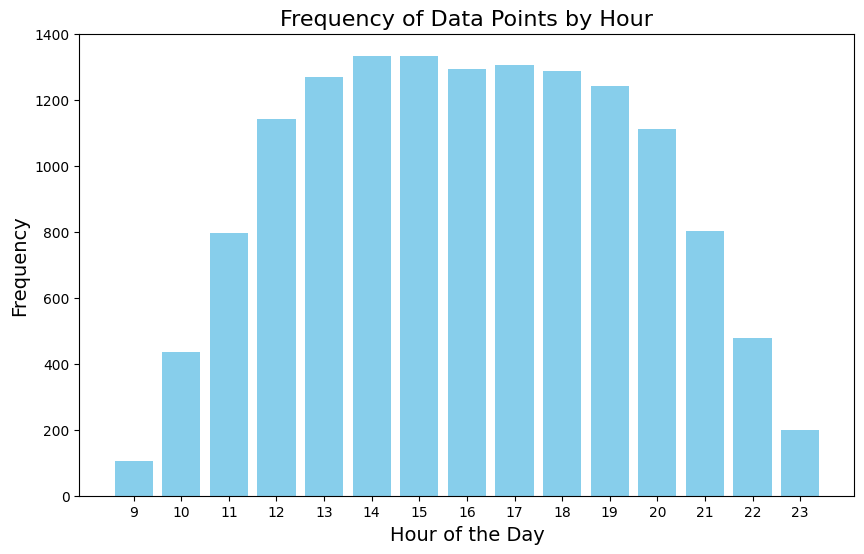

In [29]:
# Create the histogram
plt.figure(figsize=(10, 6))
plt.bar(hourly_counts.index, hourly_counts.values, color='skyblue')

# Set the title and labels
plt.title('Frequency of Data Points by Hour', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(hourly_counts.index)

# Show the plot
plt.show()

The distribution of valid data points appears to follow a normal distribution, with a peak around hours 15, 16, and 17. This likely reflects the natural variation in solar irradiance throughout the day, with the highest levels occurring when the sun is at its peak.The concentration of valid data during these hours suggests that the measurement equipment is effectively capturing expected solar patterns during peak sunlight. The absence of valid data outside these hours might be due to operational factors, such as lower solar angles, increased cloud cover, or equipment settings that are less effective in recording irradiance during non-peak hours, rather than indicating data malfunction

There are no valid solar irradiance data between 00:00 and 08:00. This could potentially correlate with other sun related variables, so this relationship will be examined.

In [30]:
print(filtered_data.columns)

Index(['Timestamp', 'maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour',
       'uvIndex', 'moon_illumination', 'moonrise', 'moonset', 'sunrise',
       'sunset', 'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC',
       'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure',
       'tempC', 'visibility', 'winddirDegree', 'windspeedKmph', 'DHI', 'DNI',
       'GHI', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Cloud Type',
       'Dew Point', 'Solar Zenith Angle', 'Surface Albedo', 'Wind Speed',
       'Relative Humidity', 'Temperature', 'Pressure', '% Baseline', 'Hour'],
      dtype='object')


In [31]:
print(filtered_data[['Timestamp', 'sunrise', 'sunset']])

                Timestamp  sunrise   sunset
12    2014-01-01 12:00:00  7:12 AM  4:22 PM
13    2014-01-01 13:00:00  7:12 AM  4:22 PM
14    2014-01-01 14:00:00  7:12 AM  4:22 PM
15    2014-01-01 15:00:00  7:12 AM  4:22 PM
16    2014-01-01 16:00:00  7:12 AM  4:22 PM
...                   ...      ...      ...
32847 2017-09-30 15:00:00  5:40 AM  5:26 PM
32848 2017-09-30 16:00:00  5:40 AM  5:26 PM
32849 2017-09-30 17:00:00  5:40 AM  5:26 PM
32850 2017-09-30 18:00:00  5:40 AM  5:26 PM
32851 2017-09-30 19:00:00  5:40 AM  5:26 PM

[14147 rows x 3 columns]


Even without accounting for moonlight, it is evident that despite the sun rising as early as 5 AM, no valid solar irradiance data were recorded at 5, 6, 7, or 8 AM. This suggests that the absence of data during these hours is likely due to the equipment being turned off because of insufficient solar irradiance, rather than malfunction on the measuring equipment.

For this reason, the missing data between 00:00 and 08:00 will be filled with zeros. This accurately reflects the physical reality of the situation and ensures consistency in the dataset. Filling these gaps with zeros also prevents misinterpretation of the data and simplifies the analysis by representing the expected absence of solar irradiance during these hours.

In [32]:
# Extract the hour from the 'Timestamp' column
data['Hour'] = data['Timestamp'].dt.hour

# Define the columns to be checked
columns = ['DHI', 'DNI', 'Clearsky DHI', 'Clearsky DNI']

# Identify rows where the hour is between 00 and 08 (inclusive)
condition = data['Hour'].between(0, 8)

# Check if all values in the irradiance columns are NaN for these rows
all_nan_condition = data.loc[condition, columns].isna().all(axis=1)

# Filter rows where all values are NaN
nan_rows = data.loc[condition & all_nan_condition]

# Print the results
if not nan_rows.empty:
    print("There are rows where all irradiance values are NaN between 00 and 08 hours:")
    print(nan_rows[['Timestamp'] + columns])
else:
    print("No rows found where all irradiance values are NaN between 00 and 08 hours.")

There are rows where all irradiance values are NaN between 00 and 08 hours:
                Timestamp  DHI  DNI  Clearsky DHI  Clearsky DNI
2380  2014-04-10 04:00:00  NaN  NaN           NaN           NaN
2404  2014-04-11 04:00:00  NaN  NaN           NaN           NaN
2428  2014-04-12 04:00:00  NaN  NaN           NaN           NaN
2452  2014-04-13 04:00:00  NaN  NaN           NaN           NaN
2476  2014-04-14 04:00:00  NaN  NaN           NaN           NaN
...                   ...  ...  ...           ...           ...
32092 2017-08-30 04:00:00  NaN  NaN           NaN           NaN
32116 2017-08-31 04:00:00  NaN  NaN           NaN           NaN
32140 2017-09-01 04:00:00  NaN  NaN           NaN           NaN
32164 2017-09-02 04:00:00  NaN  NaN           NaN           NaN
32188 2017-09-03 04:00:00  NaN  NaN           NaN           NaN

[73 rows x 5 columns]


In [33]:
# Replace invalid values (NaN and non-zero) in the specified columns with 0
data.loc[condition, columns] = data.loc[condition, columns].fillna(0)  # Replace NaN with 0

# Check if all values in the irradiance columns are NaN for these rows
all_nan_condition = data.loc[condition, columns].isna().all(axis=1)

# Filter rows where all values are NaN
nan_rows = data.loc[condition & all_nan_condition]

# Print the results
if not nan_rows.empty:
    print("There are rows where all irradiance values are NaN between 00 and 08 hours:")
    print(nan_rows[['Timestamp'] + columns])
else:
    print("No rows found where all irradiance values are NaN between 00 and 08 hours.")

No rows found where all irradiance values are NaN between 00 and 08 hours.


For test data

In [34]:
# Replace invalid values (NaN and non-zero) in the specified columns with 0
test.loc[condition, columns] = test.loc[condition, columns].fillna(0)  # Replace NaN with 0

# Check if all values in the irradiance columns are NaN for these rows
all_nan_condition = test.loc[condition, columns].isna().all(axis=1)

# Filter rows where all values are NaN
nan_rows = test.loc[condition & all_nan_condition]

# Print the results
if not nan_rows.empty:
    print("There are rows where all irradiance values are NaN between 00 and 08 hours:")
    print(nan_rows[['Timestamp'] + columns])
else:
    print("No rows found where all irradiance values are NaN between 00 and 08 hours.")

No rows found where all irradiance values are NaN between 00 and 08 hours.


When encountering missing data for a specific hour (outside the range of 00:00 to 08:00), the approach depends on the data before and after that hour:
1. Decision 1 (Values likely to represent a meaningful 0):
Condition 1: The irradiance data for the previous hour and the two preceding hours are invalid.
Condition 2: The irradiance data for the next hour and the two subsequent hours are invalid.
Condition 3: Both Condition 1 and Condition 2 are fulfilled.
Condition 4: Both the previous and the next hour irradiance data are invalid.
If any of these conditions are met, the missing values will be filled with zero.

2. Decision 2 (Values likely to represent a real non-zero value but missing due to unknown reasons):
For missing values that do not meet the criteria in Decision 1, the missing data will be imputed using MICE (Multivariate Imputation by Chained Equations). MICE is capable of leveraging the relationships between multiple variables to generate more accurate and contextually appropriate imputations. This approach ensures that the imputed value is consistent with observed patterns in the data, reducing the risk of introducing bias or inaccuracies.

Due to the lack of information regarding the reasons for the missing data, this method is employed to ensure that gaps are filled in a way that respects natural patterns and potential operational factors affecting the measurements. While there may still be some logical limitations, this approach is considered the best course of action under the circumstances.

In [35]:
print(data.columns)

Index(['Timestamp', 'maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour',
       'uvIndex', 'moon_illumination', 'moonrise', 'moonset', 'sunrise',
       'sunset', 'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC',
       'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure',
       'tempC', 'visibility', 'winddirDegree', 'windspeedKmph', 'DHI', 'DNI',
       'GHI', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Cloud Type',
       'Dew Point', 'Solar Zenith Angle', 'Surface Albedo', 'Wind Speed',
       'Relative Humidity', 'Temperature', 'Pressure', '% Baseline', 'Hour'],
      dtype='object')


Filling the missing values with 0 for data that meets the criteria outlined in Decision 1 of the previously established decision flow.

In [36]:
pd.set_option('future.no_silent_downcasting', True)

# Assume 'data' is your original DataFrame
columns = ['DHI', 'DNI', 'Clearsky DHI', 'Clearsky DNI']
data['Hour'] = data['Timestamp'].dt.hour

# Make a copy of the original DataFrame to store imputed data
data_imputed_1 = data.copy()
data_imputed_1 = data_imputed_1.sort_values(by='Timestamp', ascending=True)

# Function to handle the updated imputation conditions
def handle_imputation(row, data):
    hour = row['Hour']
    if hour > 8:  # Skip hours between 00 and 08
        # Previous hours
        previous_hour = hour - 1
        two_previous_hour = hour - 2

        # Next hours
        next_hour = hour + 1
        two_next_hour = hour + 2

        # Get data from previous and next hours
        previous_data = data[(data['Hour'] == previous_hour) & (data['Timestamp'].dt.date == row['Timestamp'].date())][columns]
        two_previous_data = data[(data['Hour'] == two_previous_hour) & (data['Timestamp'].dt.date == row['Timestamp'].date())][columns]
        next_data = data[(data['Hour'] == next_hour) & (data['Timestamp'].dt.date == row['Timestamp'].date())][columns]
        two_next_data = data[(data['Hour'] == two_next_hour) & (data['Timestamp'].dt.date == row['Timestamp'].date())][columns]

        # Condition 1: Previous hour and 2 previous hour row irradiance data are invalid
        condition_1 = (
            (previous_data.isnull().all().all() or (previous_data == 0).all().all()) and
            (two_previous_data.isnull().all().all() or (two_previous_data == 0).all().all())
        )

        # Condition 2: Next hour and 2 next hour row irradiance data are invalid
        condition_2 = (
            (next_data.isnull().all().all() or (next_data == 0).all().all()) and
            (two_next_data.isnull().all().all() or (two_next_data == 0).all().all())
        )

        # Condition 3: Both condition 1 and 2 are fulfilled
        condition_3 = condition_1 and condition_2

        # Condition 4: Both the previous and next hour irradiance data are invalid
        condition_4 = (
            (previous_data.isnull().all().all() or (previous_data == 0).all().all()) and
            (next_data.isnull().all().all() or (next_data == 0).all().all())
        )

        # If any condition is met, fill the missing values with zero
        if condition_1 or condition_2 or condition_3 or condition_4:
            return row[columns].fillna(0).astype(float)
        else:
            # Leave the row unchanged if none of the conditions are met
            return row[columns]
    return row[columns]

# Apply the function to each row where missing data is present
for index, row in data_imputed_1.iterrows():
    if row[columns].isnull().any():
        data_imputed_1.loc[index, columns] = handle_imputation(row, data_imputed_1).values

data_imputed_1.drop('Hour', axis=1, inplace=True)

For test data

In [37]:
pd.set_option('future.no_silent_downcasting', True)

columns = ['DHI', 'DNI', 'Clearsky DHI', 'Clearsky DNI']
test['Hour'] = test['Timestamp'].dt.hour

# Make a copy of the original DataFrame to store imputed data
test_imputed_1 = test.copy()
test_imputed_1 = test_imputed_1.sort_values(by='Timestamp', ascending=True)

# Function to handle the updated imputation conditions
def handle_imputation(row, test):
    hour = row['Hour']
    if hour > 8:  # Skip hours between 00 and 08
        # Previous hours
        previous_hour = hour - 1
        two_previous_hour = hour - 2

        # Next hours
        next_hour = hour + 1
        two_next_hour = hour + 2

        # Get data from previous and next hours
        previous_data = test[(test['Hour'] == previous_hour) & (test['Timestamp'].dt.date == row['Timestamp'].date())][columns]
        two_previous_data = test[(test['Hour'] == two_previous_hour) & (test['Timestamp'].dt.date == row['Timestamp'].date())][columns]
        next_data = test[(test['Hour'] == next_hour) & (test['Timestamp'].dt.date == row['Timestamp'].date())][columns]
        two_next_data = test[(test['Hour'] == two_next_hour) & (test['Timestamp'].dt.date == row['Timestamp'].date())][columns]

        # Condition 1: Previous hour and 2 previous hour row irradiance data are invalid
        condition_1 = (
            (previous_data.isnull().all().all() or (previous_data == 0).all().all()) and
            (two_previous_data.isnull().all().all() or (two_previous_data == 0).all().all())
        )

        # Condition 2: Next hour and 2 next hour row irradiance data are invalid
        condition_2 = (
            (next_data.isnull().all().all() or (next_data == 0).all().all()) and
            (two_next_data.isnull().all().all() or (two_next_data == 0).all().all())
        )

        # Condition 3: Both condition 1 and 2 are fulfilled
        condition_3 = condition_1 and condition_2

        # Condition 4: Both the previous and next hour irradiance data are invalid
        condition_4 = (
            (previous_data.isnull().all().all() or (previous_data == 0).all().all()) and
            (next_data.isnull().all().all() or (next_data == 0).all().all())
        )

        # If any condition is met, fill the missing values with zero
        if condition_1 or condition_2 or condition_3 or condition_4:
            return row[columns].fillna(0).astype(float)
        else:
            # Leave the row unchanged if none of the conditions are met
            return row[columns]
    return row[columns]

# Apply the function to each row where missing data is present
for index, row in test_imputed_1.iterrows():
    if row[columns].isnull().any():
        test_imputed_1.loc[index, columns] = handle_imputation(row, test_imputed_1).values

test_imputed_1.drop('Hour', axis=1, inplace=True)

Imputing the missing values that meet the criteria for condition two in the previously established decision flow.

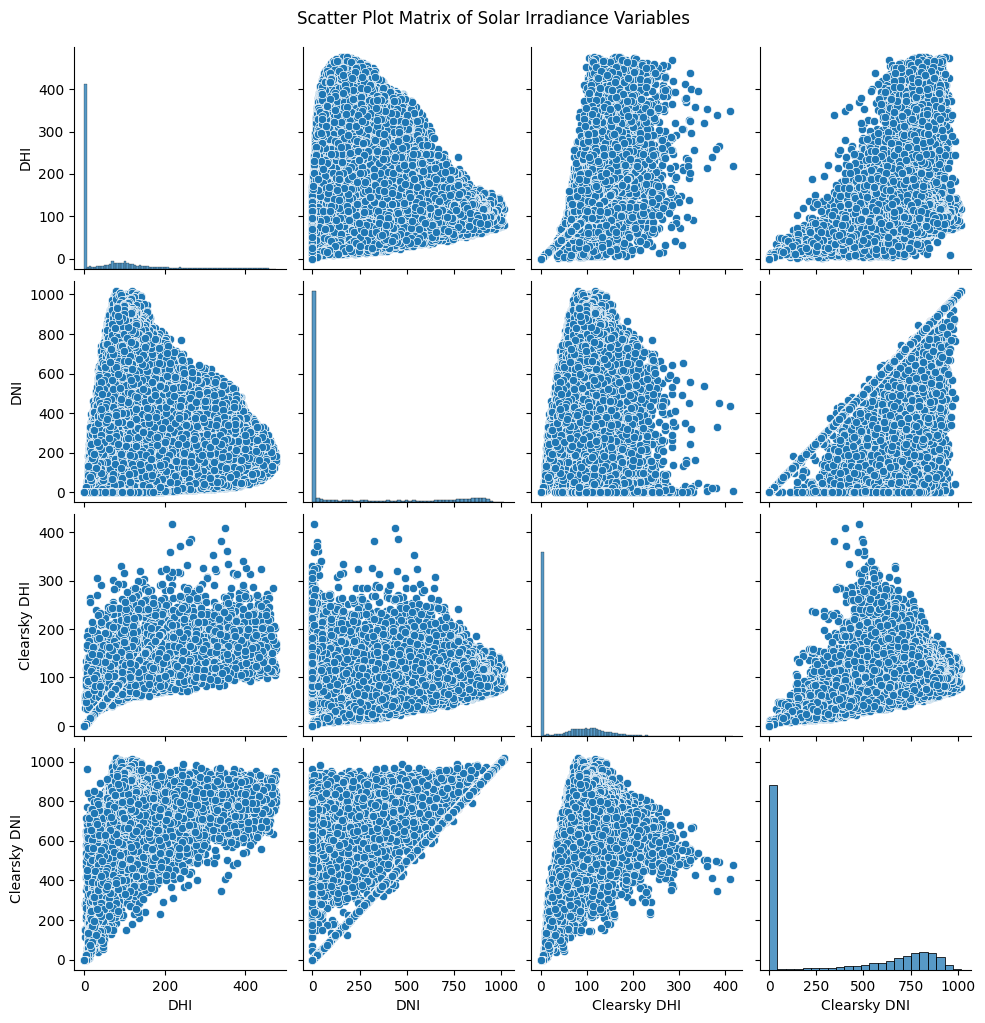

In [38]:
# Select the columns to analyze
columns_for_analysis = ['DHI', 'DNI', 'Clearsky DHI', 'Clearsky DNI']

# Plot the scatter plot matrix
sns.pairplot(data_imputed_1[columns_for_analysis])
plt.suptitle("Scatter Plot Matrix of Solar Irradiance Variables", y=1.02)
plt.show()

The relationships between the solar irradiance variables—DHI, DNI, Clearsky DHI, and Clearsky DNI—exhibit clear signs of non-linearity. This is evidenced by the triangular patterns, curved relationships, and scatter observed in the scatter plot matrix. These non-linear interactions suggest that the data cannot be accurately captured by a linear model alone. Although there is some linearity between DNI and Clearsky DNI, the overall complexity and presence of non-linear patterns across other variable pairs indicate that a non-linear model, such as RandomForestRegressor, is better suited for imputing missing values. This approach will more effectively capture the full range of interactions and relationships in the dataset.

**REVISE**

In [39]:
print(data_imputed_1.columns)

Index(['Timestamp', 'maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour',
       'uvIndex', 'moon_illumination', 'moonrise', 'moonset', 'sunrise',
       'sunset', 'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC',
       'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure',
       'tempC', 'visibility', 'winddirDegree', 'windspeedKmph', 'DHI', 'DNI',
       'GHI', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Cloud Type',
       'Dew Point', 'Solar Zenith Angle', 'Surface Albedo', 'Wind Speed',
       'Relative Humidity', 'Temperature', 'Pressure', '% Baseline'],
      dtype='object')


In [40]:
columns = ['DHI', 'DNI', 'Clearsky DHI', 'Clearsky DNI']
columns_to_impute = columns

# Drop unrelated columns and columns with missing value for imputation
numeric_data = data_imputed_1.drop(['GHI', 'Clearsky GHI', '% Baseline', 'Cloud Type', 'moonrise', 'moonset', 'sunrise', 'sunset'], axis=1).copy()

# Ensure data is sorted by time
numeric_data.sort_values(by='Timestamp', inplace=True)
numeric_data.drop('Timestamp', axis=1, inplace=True)

# Optional: Print missing values before imputation for verification
print("Missing values before imputation:")
print(numeric_data[columns_to_impute].isnull().sum())

# Step 2: Perform MICE Imputation using IterativeImputer
imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    max_iter=100,
    tol=1e-7,
    random_state=42,
    min_value=0,
    max_value=None,
    initial_strategy='mean',
    verbose=2
)

# Impute only on the numeric DataFrame
imputed_data = pd.DataFrame(imputer.fit_transform(numeric_data[columns_to_impute]), 
                            columns=columns_to_impute, 
                            index=numeric_data.index)

# Round the imputed values to the nearest integer
imputed_data = imputed_data.round(0).astype(int)

# Step 3: Place the imputed values back into the original DataFrame
data_imputed_2 = data_imputed_1.copy()

# Update the original DataFrame with imputed values
for column in columns_to_impute:
    data_imputed_2.loc[imputed_data.index, column] = imputed_data[column]

# Step 4: Add back the non-numeric columns that were excluded from imputation
non_numeric_columns = ['GHI', 'Clearsky GHI', '% Baseline', 'Cloud Type', 'moonrise', 'moonset', 'sunrise', 'sunset']
data_imputed_2[non_numeric_columns] = data_imputed_1[non_numeric_columns]

# Final check: Ensure that there are no missing values after imputation
print("DataFrame after MICE imputation:")
print(data_imputed_2[columns].isnull().sum())

Missing values before imputation:
DHI             363
DNI             363
Clearsky DHI    363
Clearsky DNI    363
dtype: int64
[IterativeImputer] Completing matrix with shape (32856, 4)
[IterativeImputer] Ending imputation round 1/100, elapsed time 3.21
[IterativeImputer] Change: 129.2769101037146, scaled tolerance: 0.0001019 
[IterativeImputer] Ending imputation round 2/100, elapsed time 6.42
[IterativeImputer] Change: 26.729999999999976, scaled tolerance: 0.0001019 
[IterativeImputer] Ending imputation round 3/100, elapsed time 9.75
[IterativeImputer] Change: 122.39000000000001, scaled tolerance: 0.0001019 
[IterativeImputer] Ending imputation round 4/100, elapsed time 13.15
[IterativeImputer] Change: 3.1300000000000168, scaled tolerance: 0.0001019 
[IterativeImputer] Ending imputation round 5/100, elapsed time 16.53
[IterativeImputer] Change: 2.109999999999985, scaled tolerance: 0.0001019 
[IterativeImputer] Ending imputation round 6/100, elapsed time 20.12
[IterativeImputer] Change

For test data

In [41]:
columns = ['DHI', 'DNI', 'Clearsky DHI', 'Clearsky DNI']
columns_to_impute = columns

# Drop unrelated columns and columns with missing value for imputation
numeric_data = test_imputed_1.drop(['GHI', 'Clearsky GHI', '% Baseline', 'Cloud Type', 'moonrise', 'moonset', 'sunrise', 'sunset'], axis=1).copy()

# Ensure data is sorted by time
numeric_data.sort_values(by='Timestamp', inplace=True)
numeric_data.drop('Timestamp', axis=1, inplace=True)

# Optional: Print missing values before imputation for verification
print("Missing values before imputation:")
print(numeric_data[columns_to_impute].isnull().sum())

# Step 2: Perform MICE Imputation using IterativeImputer
imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    max_iter=100,
    tol=1e-7,
    random_state=42,
    min_value=0,
    max_value=None,
    initial_strategy='mean',
    verbose=2
)

# Impute only on the numeric DataFrame
imputed_data = pd.DataFrame(imputer.fit_transform(numeric_data[columns_to_impute]), 
                            columns=columns_to_impute, 
                            index=numeric_data.index)

# Round the imputed values to the nearest integer
imputed_data = imputed_data.round(0).astype(int)

# Step 3: Place the imputed values back into the original DataFrame
test_imputed_2 = test_imputed_1.copy()

# Update the original DataFrame with imputed values
for column in columns_to_impute:
    test_imputed_2.loc[imputed_data.index, column] = imputed_data[column]

# Step 4: Add back the non-numeric columns that were excluded from imputation
non_numeric_columns = ['GHI', 'Clearsky GHI', '% Baseline', 'Cloud Type', 'moonrise', 'moonset', 'sunrise', 'sunset']
test_imputed_2[non_numeric_columns] = test_imputed_1[non_numeric_columns]

# Final check: Ensure that there are no missing values after imputation
print("DataFrame after MICE imputation:")
print(test_imputed_2[columns].isnull().sum())

Missing values before imputation:
DHI             32
DNI             32
Clearsky DHI    32
Clearsky DNI    32
dtype: int64
[IterativeImputer] Completing matrix with shape (2208, 4)
[IterativeImputer] Ending imputation round 1/100, elapsed time 0.64
[IterativeImputer] Change: 124.96843750000004, scaled tolerance: 9.47e-05 
[IterativeImputer] Ending imputation round 2/100, elapsed time 1.16
[IterativeImputer] Change: 24.91999999999998, scaled tolerance: 9.47e-05 
[IterativeImputer] Ending imputation round 3/100, elapsed time 1.69
[IterativeImputer] Change: 22.059999999999988, scaled tolerance: 9.47e-05 
[IterativeImputer] Ending imputation round 4/100, elapsed time 2.24
[IterativeImputer] Change: 4.620000000000008, scaled tolerance: 9.47e-05 
[IterativeImputer] Ending imputation round 5/100, elapsed time 2.78
[IterativeImputer] Change: 0.0, scaled tolerance: 9.47e-05 
[IterativeImputer] Early stopping criterion reached.
DataFrame after MICE imputation:
DHI             0
DNI             0

### Handling Missing Data in the "GHI" and "Clearsky GHI" Columns Using the Formula
**GHI = DNI * cos('Solar Zenith Angle') + DHI**

In [42]:
# Step 1: Create a new DataFrame from 'data_imputed_2' for filling the missing values
data_imputed_3 = data_imputed_2.copy()

# Step 2: Identify rows with missing values in 'GHI' or 'Clearsky GHI'
missing_ghi_rows = data_imputed_3[data_imputed_3['GHI'].isnull() | data_imputed_3['Clearsky GHI'].isnull()]

# Step 3: Fill missing 'GHI' values using the formula GHI = DNI * cos('Solar Zenith Angle') + DHI, then round to nearest int
data_imputed_3.loc[missing_ghi_rows.index, 'GHI'] = (
    data_imputed_3.loc[missing_ghi_rows.index, 'DNI'] * np.cos(np.deg2rad(data_imputed_3.loc[missing_ghi_rows.index, 'Solar Zenith Angle'])) +
    data_imputed_3.loc[missing_ghi_rows.index, 'DHI']
).round(0).astype(int)

# Step 4: Fill missing 'Clearsky GHI' values using the formula 'Clearsky GHI' = 'Clearsky DNI' * cos('Solar Zenith Angle') + 'Clearsky DHI', then round to nearest int
data_imputed_3.loc[missing_ghi_rows.index, 'Clearsky GHI'] = (
    data_imputed_3.loc[missing_ghi_rows.index, 'Clearsky DNI'] * np.cos(np.deg2rad(data_imputed_3.loc[missing_ghi_rows.index, 'Solar Zenith Angle'])) +
    data_imputed_3.loc[missing_ghi_rows.index, 'Clearsky DHI']
).round(0).astype(int)

For test data

In [43]:
# Step 1: Create a new DataFrame from 'test_imputed_2' for filling the missing values
test_imputed_3 = test_imputed_2.copy()

# Step 2: Identify rows with missing values in 'GHI' or 'Clearsky GHI'
missing_ghi_rows = test_imputed_3[test_imputed_3['GHI'].isnull() | test_imputed_3['Clearsky GHI'].isnull()]

# Step 3: Fill missing 'GHI' values using the formula GHI = DNI * cos('Solar Zenith Angle') + DHI, then round to nearest int
test_imputed_3.loc[missing_ghi_rows.index, 'GHI'] = (
    test_imputed_3.loc[missing_ghi_rows.index, 'DNI'] * np.cos(np.deg2rad(test_imputed_3.loc[missing_ghi_rows.index, 'Solar Zenith Angle'])) +
    test_imputed_3.loc[missing_ghi_rows.index, 'DHI']
).round(0).astype(int)

# Step 4: Fill missing 'Clearsky GHI' values using the formula 'Clearsky GHI' = 'Clearsky DNI' * cos('Solar Zenith Angle') + 'Clearsky DHI', then round to nearest int
test_imputed_3.loc[missing_ghi_rows.index, 'Clearsky GHI'] = (
    test_imputed_3.loc[missing_ghi_rows.index, 'Clearsky DNI'] * np.cos(np.deg2rad(test_imputed_3.loc[missing_ghi_rows.index, 'Solar Zenith Angle'])) +
    test_imputed_3.loc[missing_ghi_rows.index, 'Clearsky DHI']
).round(0).astype(int)

In [44]:
# Checking existence of missing data
missing_data = data_imputed_3.isnull().sum()
columns_with_missing = missing_data[missing_data > 0]
print(columns_with_missing)

Cloud Type     2250
% Baseline    13914
dtype: int64


It has been confirmed that there are no more missing data in the columns 'DNI', 'DHI', 'GHI', 'Clearsky DNI', 'Clearsky DHI', and 'Clearsky GHI', and there are no incorrect calculations for 'GHI' and 'Clearsky GHI'.

### Handling missing data in the 'Cloud Type' Column

Performed label encoding on the 'Cloud Type' column to simplify the imputation process.

In [45]:
print(data_imputed_3['Cloud Type'].value_counts())

Cloud Type
Clear                 9150
Probably Clear        5162
Super-Cooled Water    4547
Overlapping           4084
Cirrus                3629
Opaque Ice            1875
Water                 1588
Fog                    504
Overshooting            64
Unknown                  3
Name: count, dtype: int64


In [46]:
# Create a new DataFrame from 'data_imputed_3' for the encoding process
data_imputed_4 = data_imputed_3.copy()

# Create a LabelEncoder object
le = LabelEncoder()

# Fit the LabelEncoder only on the non-missing values of the 'Cloud Type' column
non_missing_cloud_types = data_imputed_4['Cloud Type'].dropna().astype(str)
le.fit(non_missing_cloud_types)

# Transform the non-missing values and store them in a new column, while leaving missing values as NaN
data_imputed_4['Cloud Type'] = data_imputed_4['Cloud Type'].apply(lambda x: le.transform([x])[0] if pd.notna(x) else np.nan)

# Store the encoding dictionary in a variable for later use
label_encoding_dict = dict(zip(le.classes_, le.transform(le.classes_)))

print("Label encoding completed for non-missing values, and dictionary stored in a variable.")

Label encoding completed for non-missing values, and dictionary stored in a variable.


For test data

In [47]:
# Create a new DataFrame from 'test_imputed_3' for the encoding process
test_imputed_4 = test_imputed_3.copy()

# Create a LabelEncoder object
le = LabelEncoder()

# Fit the LabelEncoder only on the non-missing values of the 'Cloud Type' column
non_missing_cloud_types = test_imputed_4['Cloud Type'].dropna().astype(str)
le.fit(non_missing_cloud_types)

# Transform the non-missing values and store them in a new column, while leaving missing values as NaN
test_imputed_4['Cloud Type'] = test_imputed_4['Cloud Type'].apply(lambda x: le.transform([x])[0] if pd.notna(x) else np.nan)

# Store the encoding dictionary in a variable for later use
label_encoding_dict = dict(zip(le.classes_, le.transform(le.classes_)))

print("Label encoding completed for non-missing values, and dictionary stored in a variable.")

Label encoding completed for non-missing values, and dictionary stored in a variable.


In [48]:
print(data_imputed_4['Cloud Type'].value_counts())

Cloud Type
1.0    9150
6.0    5162
7.0    4547
4.0    4084
0.0    3629
3.0    1875
9.0    1588
2.0     504
5.0      64
8.0       3
Name: count, dtype: int64


RandomForestClassifier is used to impute the "Cloud Type" column because it effectively handles the complex and non-linear relationships between categorical data and other meteorological features. This model-based approach is particularly well-suited for categorical variables like "Cloud Type," as it predicts the most likely category based on patterns observed in the data, ensuring robust and realistic imputations.

In [49]:
# Step 1: Create a new DataFrame from 'data_imputed_4' for imputation
data_imputed_5 = data_imputed_4.copy()

# Step 2: Define the 'Cloud Type' column
column_to_impute = 'Cloud Type'

# Step 3: Filter out non-numeric columns, except for 'Cloud Type'
numeric_columns = data_imputed_5.select_dtypes(include=['int', 'float']).columns
columns_to_use = numeric_columns.drop(column_to_impute, errors='ignore')  # Ensure 'Cloud Type' is not included

# Step 4: Separate the data into training (non-missing) and testing (missing) sets
train_data = data_imputed_5.dropna(subset=[column_to_impute])
test_data = data_imputed_5[data_imputed_5[column_to_impute].isna()]

# Step 5: Fit the RandomForestClassifier on the non-missing numeric data
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(train_data[columns_to_use], train_data[column_to_impute])

# Step 6: Predict the missing values
predictions = clf.predict(test_data[columns_to_use])

# Step 7: Fill in the missing values in the original DataFrame
data_imputed_5.loc[test_data.index, column_to_impute] = predictions

In [50]:
# Reverse the label encoding by creating a reverse dictionary
reverse_label_encoding_dict = {v: k for k, v in label_encoding_dict.items()}
data_imputed_5['Cloud Type'] = data_imputed_5['Cloud Type'].map(reverse_label_encoding_dict)

For test data

In [51]:
# Step 1: Create a new DataFrame from 'test_imputed_4' for imputation
test_imputed_5 = test_imputed_4.copy()

# Step 2: Define the 'Cloud Type' column
column_to_impute = 'Cloud Type'

# Step 3: Filter out non-numeric columns, except for 'Cloud Type'
numeric_columns = test_imputed_5.select_dtypes(include=['int', 'float']).columns
columns_to_use = numeric_columns.drop(column_to_impute, errors='ignore')  # Ensure 'Cloud Type' is not included

# Step 4: Separate the data into training (non-missing) and testing (missing) sets
train_data = test_imputed_5.dropna(subset=[column_to_impute])
test_data = test_imputed_5[test_imputed_5[column_to_impute].isna()]

# Step 5: Fit the RandomForestClassifier on the non-missing numeric data
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(train_data[columns_to_use], train_data[column_to_impute])

# Step 6: Predict the missing values
predictions = clf.predict(test_data[columns_to_use])

# Step 7: Fill in the missing values in the original DataFrame
test_imputed_5.loc[test_data.index, column_to_impute] = predictions

In [52]:
# Reverse the label encoding by creating a reverse dictionary
reverse_label_encoding_dict = {v: k for k, v in label_encoding_dict.items()}
test_imputed_5['Cloud Type'] = test_imputed_5['Cloud Type'].map(reverse_label_encoding_dict)

In [53]:
# Checking existence of missing data
missing_data = data_imputed_5.isnull().sum()
columns_with_missing = missing_data[missing_data > 0]
print(columns_with_missing)

Cloud Type     1632
% Baseline    13914
dtype: int64


In [54]:
# Export the final dataset without missing data
data_imputed_5.to_excel(r"Processed Data\imputed_train_data.xlsx", index=False)
test_imputed_5.to_excel(r"Processed Data\imputed_test_data.xlsx", index=False)

# Descriptive Analysis

In [55]:
data2 = pd.read_excel(r"Processed Data\imputed_train_data.xlsx")
data2 = data2.dropna(subset = '% Baseline')

In [56]:
print(data2.columns)

Index(['Timestamp', 'maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour',
       'uvIndex', 'moon_illumination', 'moonrise', 'moonset', 'sunrise',
       'sunset', 'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC',
       'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure',
       'tempC', 'visibility', 'winddirDegree', 'windspeedKmph', 'DHI', 'DNI',
       'GHI', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Cloud Type',
       'Dew Point', 'Solar Zenith Angle', 'Surface Albedo', 'Wind Speed',
       'Relative Humidity', 'Temperature', 'Pressure', '% Baseline'],
      dtype='object')


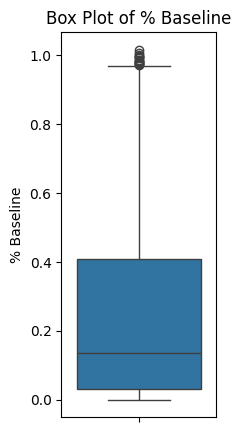

In [57]:
# Create a box plot for '% Baseline'
plt.figure(figsize=(2, 5))
sns.boxplot(y=data2['% Baseline'])
plt.title('Box Plot of % Baseline')
plt.ylabel('% Baseline')
plt.show()

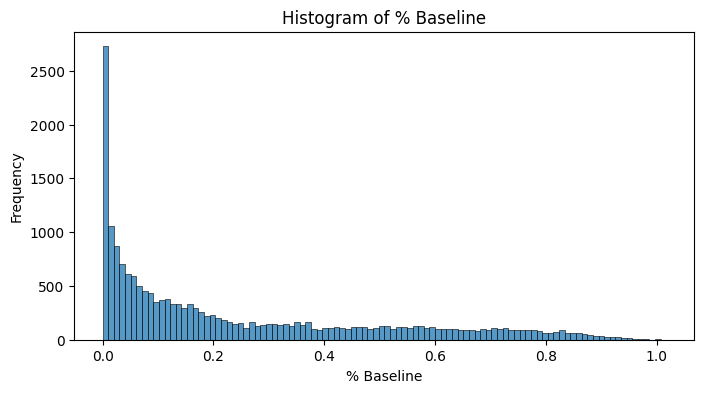

In [58]:
# Create a histogram for '% Baseline'
plt.figure(figsize=(8, 4))
sns.histplot(data2['% Baseline'], bins=100)
plt.title('Histogram of % Baseline')
plt.xlabel('% Baseline')
plt.ylabel('Frequency')
plt.show()

In [59]:
# Calculate the interquartile range (IQR)
Q1 = data2['% Baseline'].quantile(0.25)
Q3 = data2['% Baseline'].quantile(0.75)

print(min(data2['% Baseline']))
print(Q1)
print(Q3)
print(max(data2['% Baseline']))

0.0
0.0318
0.4077
1.0169


The efficiency of the solar panel system, as indicated by the % Baseline, exhibits a notable skew towards lower values. Specifically, 25% of the observations fall below 0.0318%, and 75% are below 0.4077%. This suggests that a significant portion of the system's operation tends to achieve baseline percentages that are relatively low. The maximum observed value of % Baseline is 1.0169%, which, while representing the highest efficiency recorded, still remains modest. These results indicate that the solar panel system typically operates at a low percentage of its baseline efficiency, with only occasional instances of slightly higher efficiency. This tendency towards lower efficiency values suggests potential inefficiencies in the system or external factors limiting performance, warranting further investigation to identify and address the underlying causes.

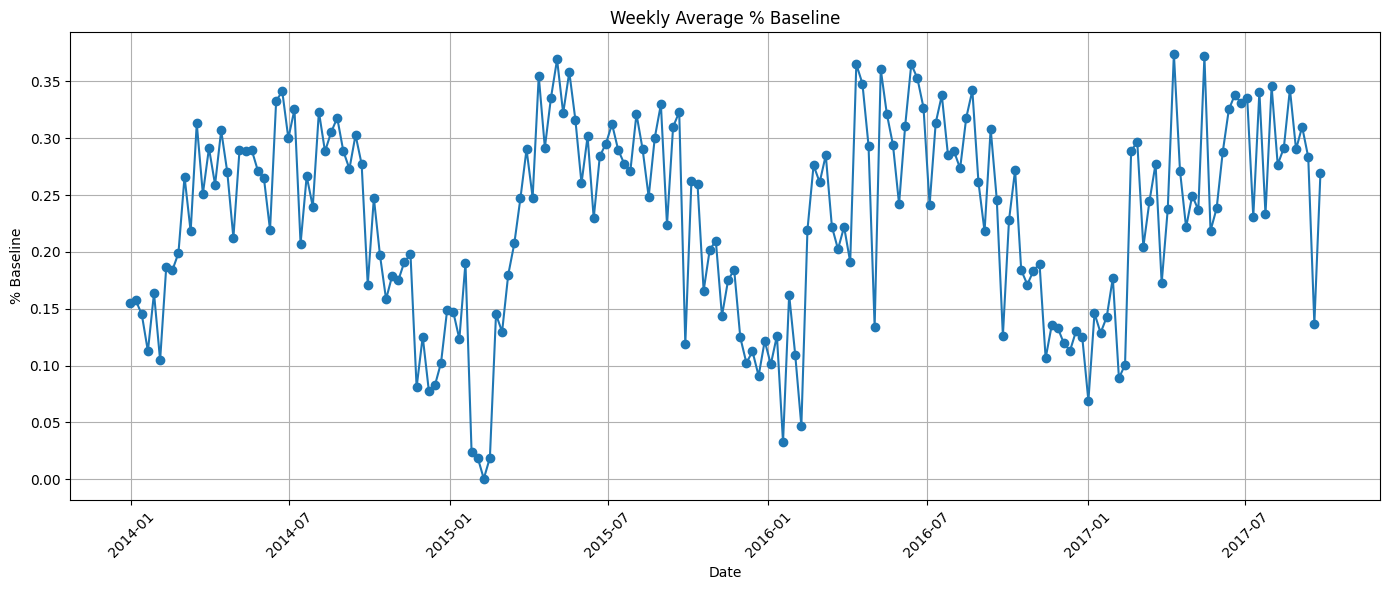

In [60]:
# Create a 'Year-Week' column directly from 'Timestamp'
data2['Year-Week'] = data2['Timestamp'].dt.to_period('W').astype(str)

# Aggregate by 'Year-Week', calculating the mean % Baseline for each week
weekly_baseline = data2.groupby('Year-Week')['% Baseline'].mean().reset_index()

# Convert 'Year-Week' to a datetime object for plotting purposes
# Here we take the start of the week for the date
weekly_baseline['Year-Week'] = pd.to_datetime(weekly_baseline['Year-Week'].apply(lambda x: x.split('/')[0]))

# Plot the aggregated data
plt.figure(figsize=(14, 6))
plt.plot(weekly_baseline['Year-Week'], weekly_baseline['% Baseline'], marker='o')
plt.title('Weekly Average % Baseline')
plt.xlabel('Date')
plt.ylabel('% Baseline')
plt.grid(True)  # Adds a grid for better readability
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlap
plt.show()

plt.show()

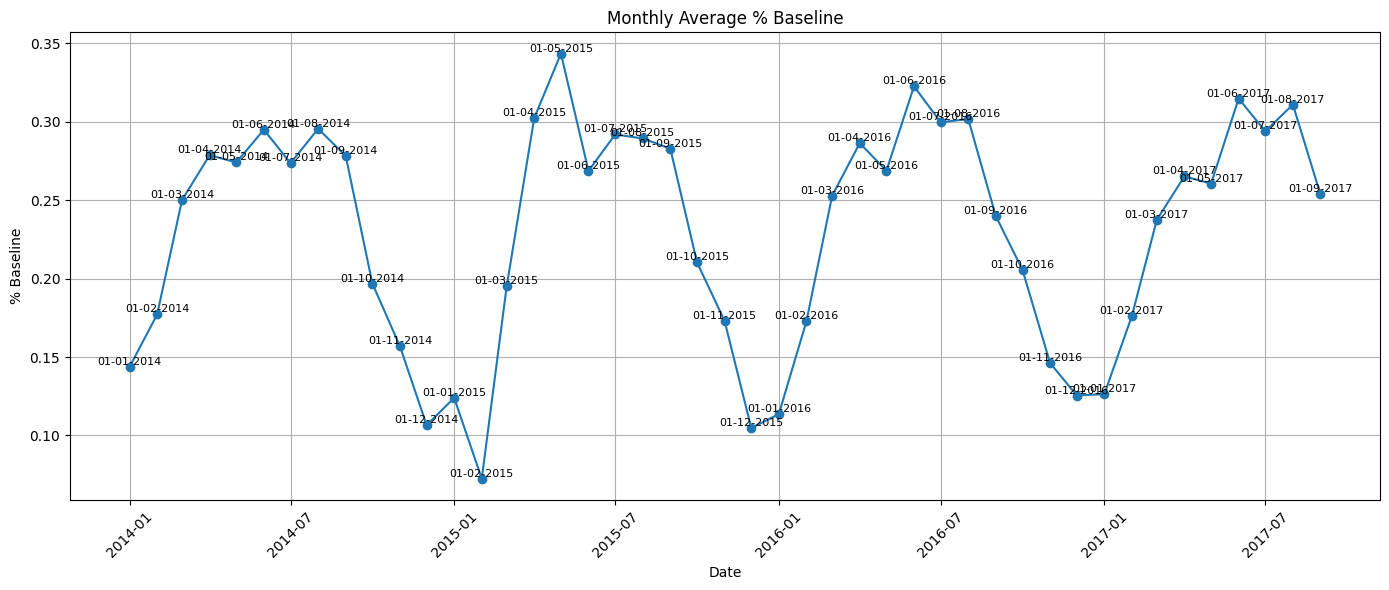

In [61]:
# Ensure 'Timestamp' is in datetime format
data2['Timestamp'] = pd.to_datetime(data2['Timestamp'])

# Create a 'Year-Month' column directly from 'Timestamp'
data2['Year-Month'] = data2['Timestamp'].dt.to_period('M').astype(str)

# Aggregate by 'Year-Month', calculating the mean % Baseline for each month
monthly_baseline = data2.groupby('Year-Month')['% Baseline'].mean().reset_index()

# Convert 'Year-Month' to a datetime object for plotting purposes
monthly_baseline['Year-Month'] = pd.to_datetime(monthly_baseline['Year-Month'])

# Plot the data with markers
plt.figure(figsize=(14, 6))
plt.plot(monthly_baseline['Year-Month'], monthly_baseline['% Baseline'], marker='o')

# Add date labels for each marker
for i in range(len(monthly_baseline)):
    plt.text(monthly_baseline['Year-Month'][i], monthly_baseline['% Baseline'][i],
             monthly_baseline['Year-Month'][i].strftime('%d-%m-%Y'),  # Format the label as dd-mm-yyyy
             ha='center', va='bottom', fontsize=8)  # Adjust the alignment and font size

# Customize the plot
plt.title('Monthly Average % Baseline')
plt.xlabel('Date')
plt.ylabel('% Baseline')
plt.grid(True)  # Adds a grid for better readability
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlap

# Show the plot
plt.show()

It can be observed that the `% Baseline` tends to peak consistently around the months of April to September each year. This recurring pattern suggests a seasonal influence on baseline performance, where certain conditions during these months contribute to higher efficiency or output. The trend highlights the possibility of favorable environmental factors or operational conditions during this period, which warrant further investigation to understand the underlying causes and optimize performance during other parts of the year.

In [62]:
data2.columns

Index(['Timestamp', 'maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour',
       'uvIndex', 'moon_illumination', 'moonrise', 'moonset', 'sunrise',
       'sunset', 'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC',
       'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure',
       'tempC', 'visibility', 'winddirDegree', 'windspeedKmph', 'DHI', 'DNI',
       'GHI', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Cloud Type',
       'Dew Point', 'Solar Zenith Angle', 'Surface Albedo', 'Wind Speed',
       'Relative Humidity', 'Temperature', 'Pressure', '% Baseline',
       'Year-Week', 'Year-Month'],
      dtype='object')

In [63]:
data_monthly = data2.copy()
data_monthly.drop(['sunrise', 'sunset', 'moonrise', 'moonset', 'Cloud Type', 'Year-Week', 'Year-Month'], axis=1, inplace=True)
data_monthly.columns

Index(['Timestamp', 'maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour',
       'uvIndex', 'moon_illumination', 'DewPointC', 'FeelsLikeC', 'HeatIndexC',
       'WindChillC', 'WindGustKmph', 'cloudcover', 'humidity', 'precipMM',
       'pressure', 'tempC', 'visibility', 'winddirDegree', 'windspeedKmph',
       'DHI', 'DNI', 'GHI', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI',
       'Dew Point', 'Solar Zenith Angle', 'Surface Albedo', 'Wind Speed',
       'Relative Humidity', 'Temperature', 'Pressure', '% Baseline'],
      dtype='object')

In [64]:
# Create a 'Year-Month' column for grouping
data_monthly['Year-Month'] = data_monthly['Timestamp'].dt.to_period('M')

# Group by 'Year-Month' and calculate the mean for all variables
data_monthly_grouped0 = data_monthly.drop(['mintempC', 'maxtempC'], axis=1).groupby('Year-Month').mean().reset_index()

# Group by 'Year-Month' and calculate the min and max for 'mintempC' and 'maxtempC' respectively
data_monthly_grouped1 = data_monthly.groupby('Year-Month')['mintempC'].min().reset_index()
data_monthly_grouped2 = data_monthly.groupby('Year-Month')['maxtempC'].max().reset_index()

# Merge the results into a single DataFrame
data_monthly_grouped = pd.merge(data_monthly_grouped0, data_monthly_grouped1, on='Year-Month')
data_monthly_grouped = pd.merge(data_monthly_grouped, data_monthly_grouped2, on='Year-Month')

# Convert 'Year-Month' back to datetime for easier plotting and analysis if needed
data_monthly_grouped['Year-Month'] = data_monthly_grouped['Year-Month'].dt.to_timestamp()

# Display the aggregated data
print(data_monthly_grouped)

   Year-Month                     Timestamp  totalSnow_cm    sunHour  \
0  2014-01-01 2014-01-17 08:42:53.493975808      0.169880   6.691165   
1  2014-02-01 2014-02-16 06:10:56.603773696      0.543711   6.849686   
2  2014-03-01 2014-03-16 16:14:02.727272704      0.157045   8.788864   
3  2014-04-01 2014-04-16 03:11:47.949790976      0.317782  12.157531   
4  2014-05-01 2014-05-16 15:53:35.730337024      0.000000  13.196442   
5  2014-06-01 2014-06-16 00:30:00.000000000      0.000000  13.493333   
6  2014-07-01 2014-07-16 09:08:48.260869632      0.000000  13.630072   
7  2014-08-01 2014-08-16 10:25:43.887775488      0.000000  13.205411   
8  2014-09-01 2014-09-15 19:48:45.000000000      0.000000  11.478795   
9  2014-10-01 2014-10-16 12:52:42.531645440      0.000000   8.804557   
10 2014-11-01 2014-11-15 11:09:11.532033536      0.398050   6.998050   
11 2014-12-01 2014-12-16 02:22:40.975609856      0.008537   5.495122   
12 2015-01-01 2015-01-16 03:42:10.588235264      0.276471   6.46

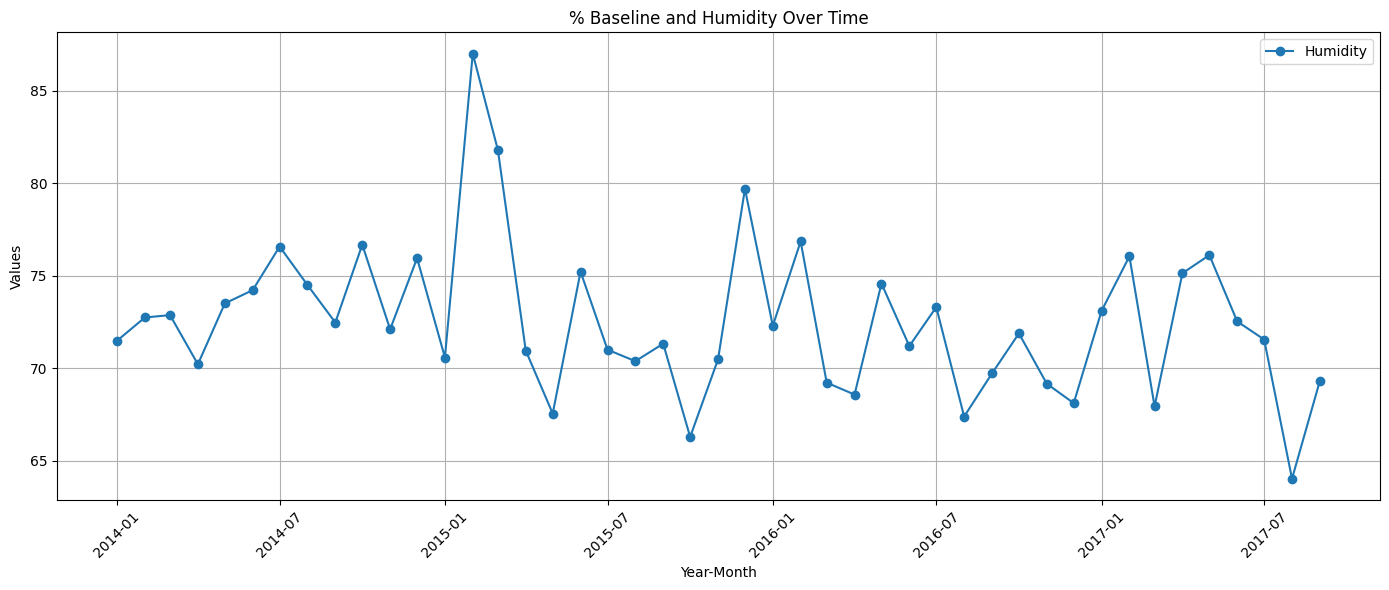

In [65]:
# Plotting '% Baseline' and 'Humidity' against 'Year-Month'
plt.figure(figsize=(14, 6))

# Plot % Baseline
# plt.plot(data_monthly_grouped['Year-Month'], data_monthly_grouped['% Baseline'], label='% Baseline', marker='o')

# Plot Humidity
plt.plot(data_monthly_grouped['Year-Month'], data_monthly_grouped['humidity'], label='Humidity', marker='o')

# Adding titles and labels
plt.title('% Baseline and Humidity Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Values')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)  # Adds gridlines
plt.legend()  # Add a legend to differentiate the lines
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Show the plot
plt.show()

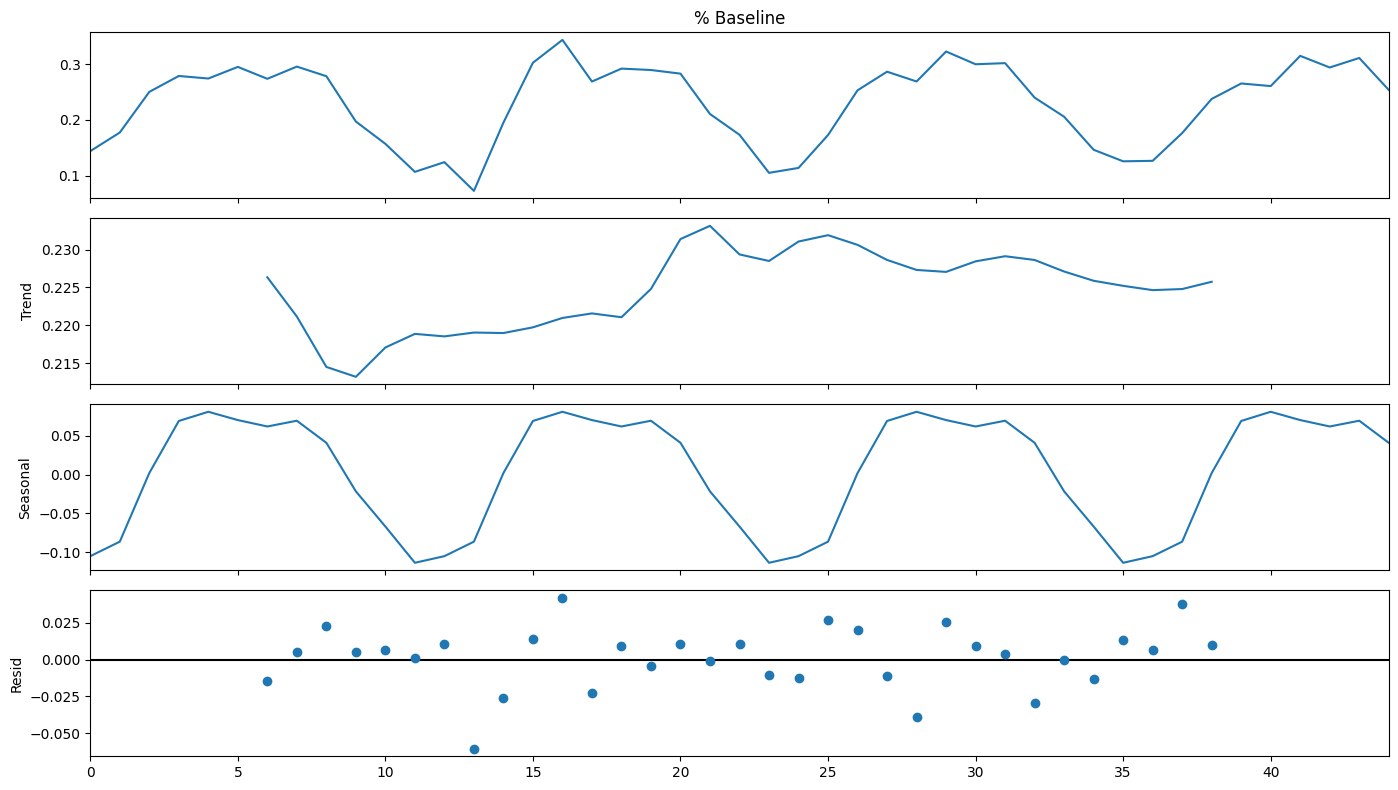

In [66]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Ensure 'Year-Month' is set as the index for time series analysis
# data_monthly_grouped.set_index('Year-Month', inplace=True)

# Perform seasonal decomposition
result = seasonal_decompose(data_monthly_grouped['% Baseline'], model='additive', period=12)

plt.rc("figure",figsize=(14,8))
# Plot the decomposition
result.plot()
plt.show()

In [67]:
data_monthly_grouped.columns

Index(['Year-Month', 'Timestamp', 'totalSnow_cm', 'sunHour', 'uvIndex',
       'moon_illumination', 'DewPointC', 'FeelsLikeC', 'HeatIndexC',
       'WindChillC', 'WindGustKmph', 'cloudcover', 'humidity', 'precipMM',
       'pressure', 'tempC', 'visibility', 'winddirDegree', 'windspeedKmph',
       'DHI', 'DNI', 'GHI', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI',
       'Dew Point', 'Solar Zenith Angle', 'Surface Albedo', 'Wind Speed',
       'Relative Humidity', 'Temperature', 'Pressure', '% Baseline',
       'mintempC', 'maxtempC'],
      dtype='object')

In [68]:
# Create a 'Month' column
data_monthly_grouped['Month'] = data_monthly_grouped['Timestamp'].dt.month

# Define peak and off-peak periods
peak_period = data_monthly_grouped[(data_monthly_grouped['Month'] >= 4) & (data_monthly_grouped['Month'] <= 9)]
off_peak_period = data_monthly_grouped[(data_monthly_grouped['Month'] < 4) | (data_monthly_grouped['Month'] > 9)]

# Select the features you want to compare
features = data_monthly_grouped.columns.drop(['Year-Month', 'Timestamp']).to_list()

# Calculate the mean for each feature during peak and off-peak periods
peak_means = peak_period[features].mean()
off_peak_means = off_peak_period[features].mean()

# Create a DataFrame for plotting
comparison_df = pd.DataFrame({'Variable': data_monthly_grouped.columns.drop(['Year-Month', 'Timestamp']).to_list(), 'Peak Period': peak_means, 'Off-Peak Period': off_peak_means, 'Difference': peak_means - off_peak_means})


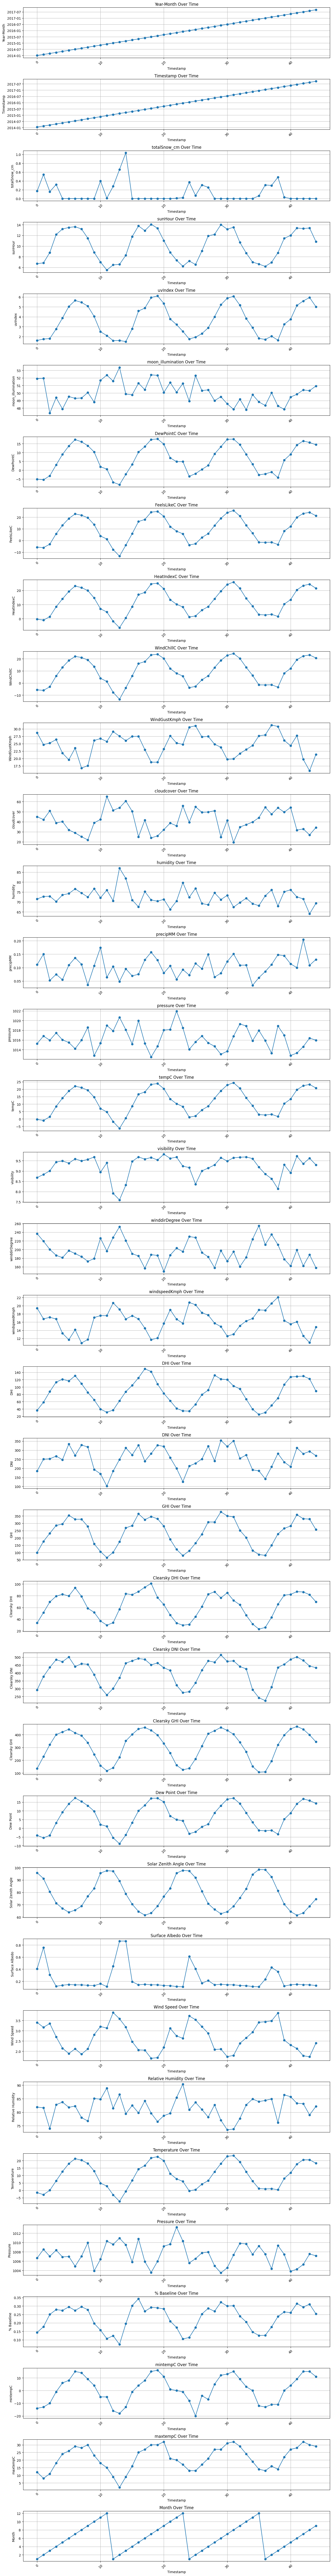

In [69]:
# Number of columns
n_cols = len(data_monthly_grouped.columns)

# Set up the plotting space
plt.figure(figsize=(14, n_cols * 3))  # Adjust the figure size depending on the number of variables

# Loop through each column and create a plot
for i, col in enumerate(data_monthly_grouped.columns):
    plt.subplot(n_cols, 1, i + 1)
    plt.plot(data_monthly_grouped.index, data_monthly_grouped[col], marker='o')
    plt.title(f'{col} Over Time')
    plt.xlabel('Timestamp')
    plt.ylabel(col)
    plt.grid(True)
    plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [70]:
print(data2.columns)

Index(['Timestamp', 'maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour',
       'uvIndex', 'moon_illumination', 'moonrise', 'moonset', 'sunrise',
       'sunset', 'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC',
       'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure',
       'tempC', 'visibility', 'winddirDegree', 'windspeedKmph', 'DHI', 'DNI',
       'GHI', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Cloud Type',
       'Dew Point', 'Solar Zenith Angle', 'Surface Albedo', 'Wind Speed',
       'Relative Humidity', 'Temperature', 'Pressure', '% Baseline',
       'Year-Week', 'Year-Month'],
      dtype='object')


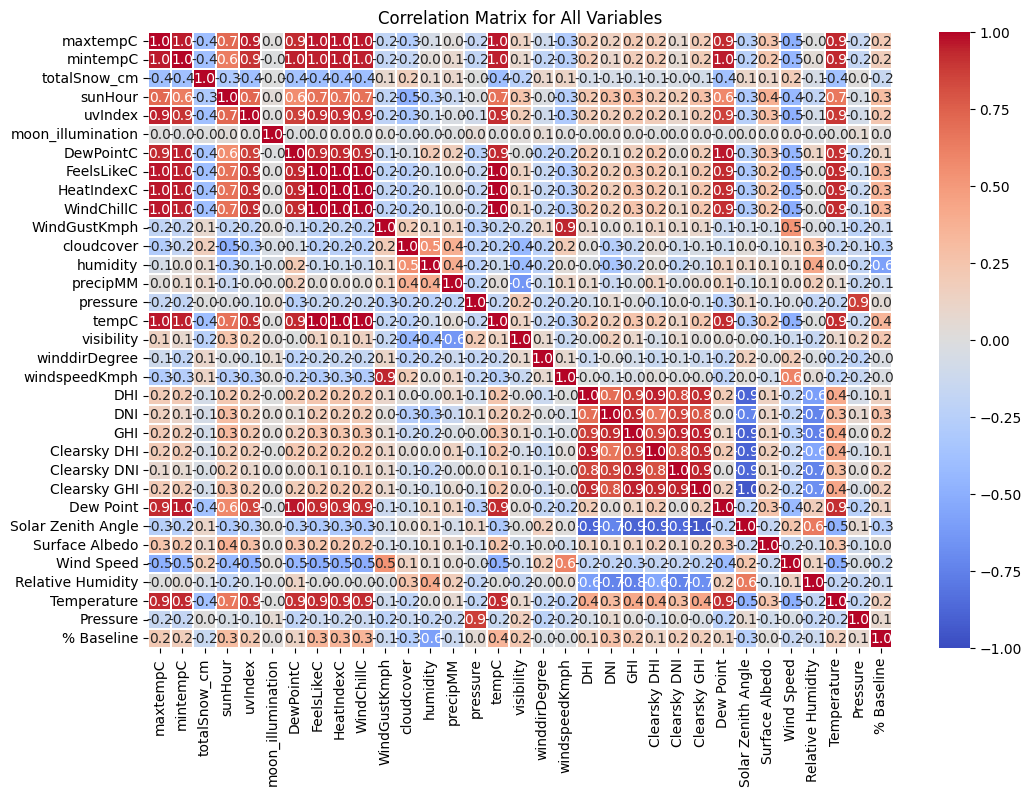

In [71]:
excluded_columns = ['Timestamp', 'moonrise', 'moonset', 'sunrise', 'sunset', 'Year-Week', 'Year-Month', 'Cloud Type']
corr_matrix = data2.drop(excluded_columns, axis=1).dropna().corr(method='spearman')

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".1f", linewidths=0.1, vmin=-1, vmax=1)
plt.title('Correlation Matrix for All Variables')
plt.show()

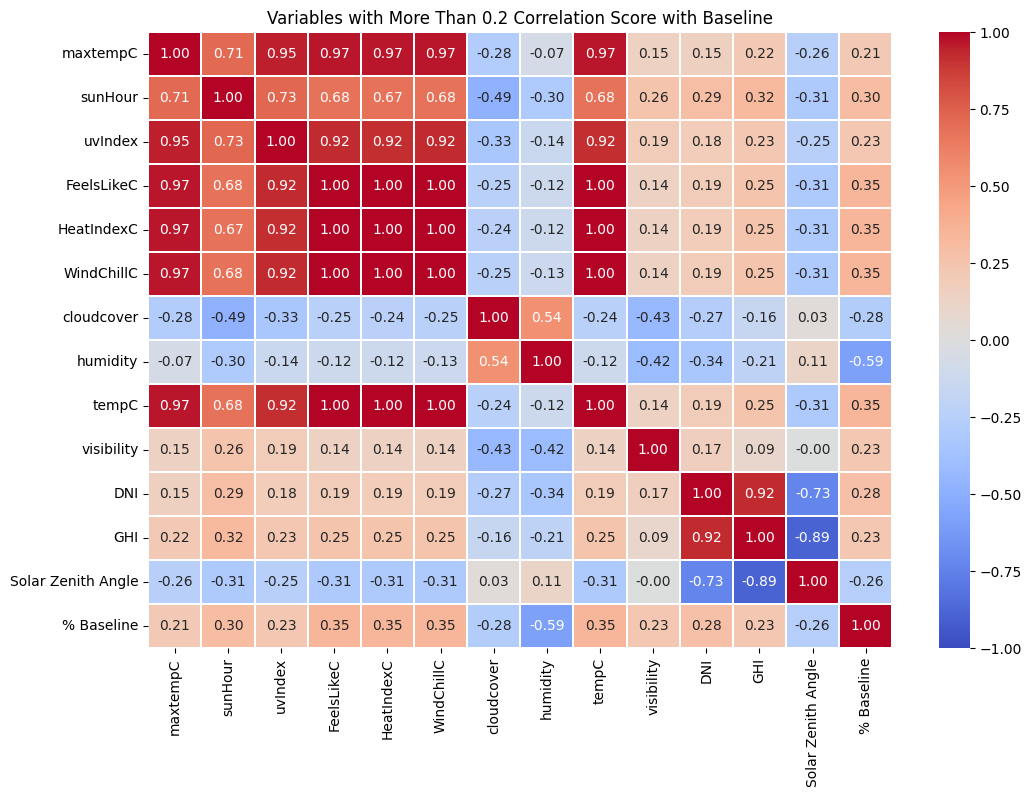

In [72]:
# Filtering the correlation matrix to drop columns with correlation lower than the threshold
filtered_columns = corr_matrix.columns[corr_matrix['% Baseline'].abs() >= 0.2]
filtered_corr_matrix = corr_matrix.loc[filtered_columns, filtered_columns]

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.1, vmin=-1, vmax=1)
plt.title('Variables with More Than 0.2 Correlation Score with Baseline')
plt.show()


# Dimensionality Reduction

In [73]:
data2 = pd.read_excel(r"Processed Data\imputed_train_data.xlsx")
test2 = pd.read_excel(r"Processed Data\imputed_test_data.xlsx")

## Identifying multicollinearity

In [74]:
data2 = data2.dropna(subset = '% Baseline')
print(data2.columns)

Index(['Timestamp', 'maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour',
       'uvIndex', 'moon_illumination', 'moonrise', 'moonset', 'sunrise',
       'sunset', 'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC',
       'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure',
       'tempC', 'visibility', 'winddirDegree', 'windspeedKmph', 'DHI', 'DNI',
       'GHI', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Cloud Type',
       'Dew Point', 'Solar Zenith Angle', 'Surface Albedo', 'Wind Speed',
       'Relative Humidity', 'Temperature', 'Pressure', '% Baseline'],
      dtype='object')


The variables Cloud Type, Moonrise, Moonset, Sunrise, Sunset were excluded due to their categorical nature and limited variability, which could lead to misleading or non-informative correlations in the matrix. 'Cloud Type' is excluded to do it's categorical nature

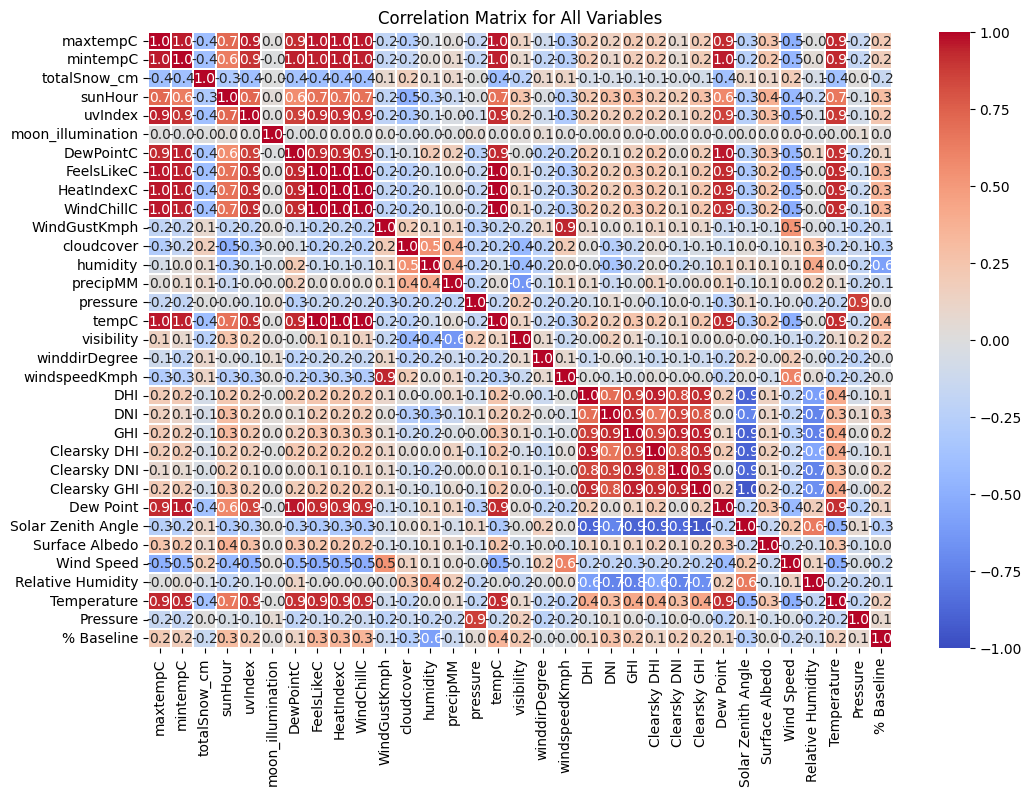

In [75]:
excluded_columns = ['Timestamp', 'moonrise', 'moonset', 'sunrise', 'sunset', 'Cloud Type']
data2_1 = data2.copy().drop(excluded_columns, axis=1)
test2_1 = test2.copy().drop(excluded_columns, axis=1)
corr_matrix = data2_1.corr(method='spearman')

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".1f", linewidths=0.1, vmin=-1, vmax=1)
plt.title('Correlation Matrix for All Variables')
plt.show()

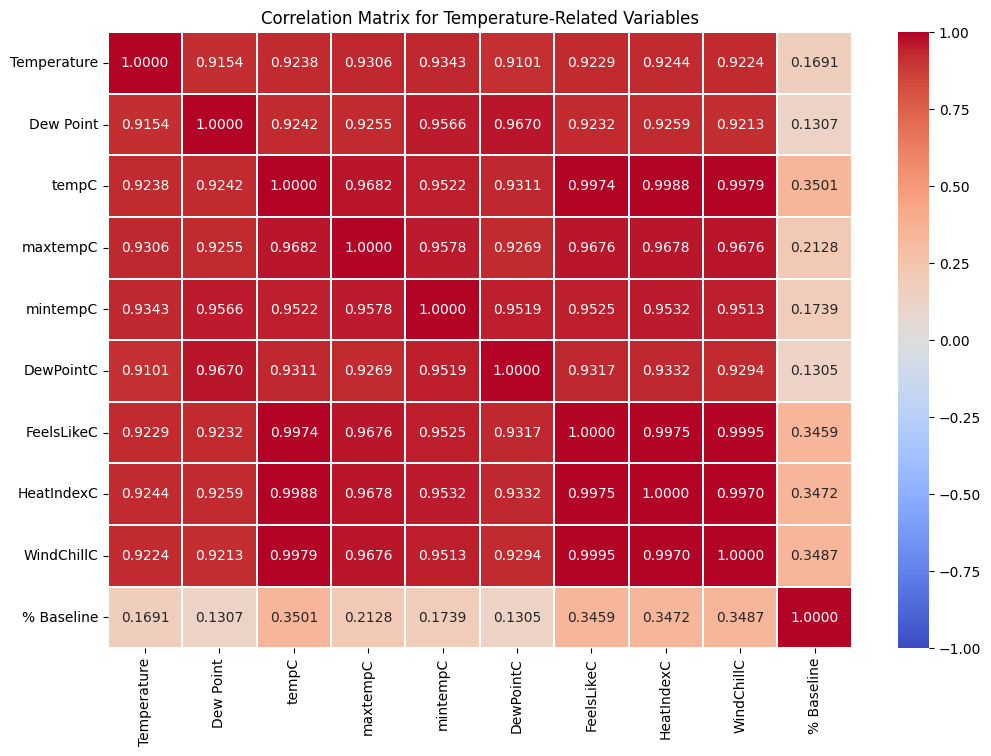

In [76]:
# List all temperature-related variables based on their names and descriptions
temperature_related_columns = [
    'Temperature',
    'Dew Point',  
    'tempC',      
    'maxtempC',   
    'mintempC',   
    'DewPointC',  
    'FeelsLikeC', 
    'HeatIndexC', 
    'WindChillC'  
]

# Perform correlation analysis among these temperature-related variables and with % Baseline
temperature_corr_matrix = data2_1[temperature_related_columns + ['% Baseline']].corr(method='spearman')

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(temperature_corr_matrix, annot=True, cmap="coolwarm", fmt=".4f", linewidths=.1, vmin=-1, vmax=1)
plt.title('Correlation Matrix for Temperature-Related Variables')
plt.show()

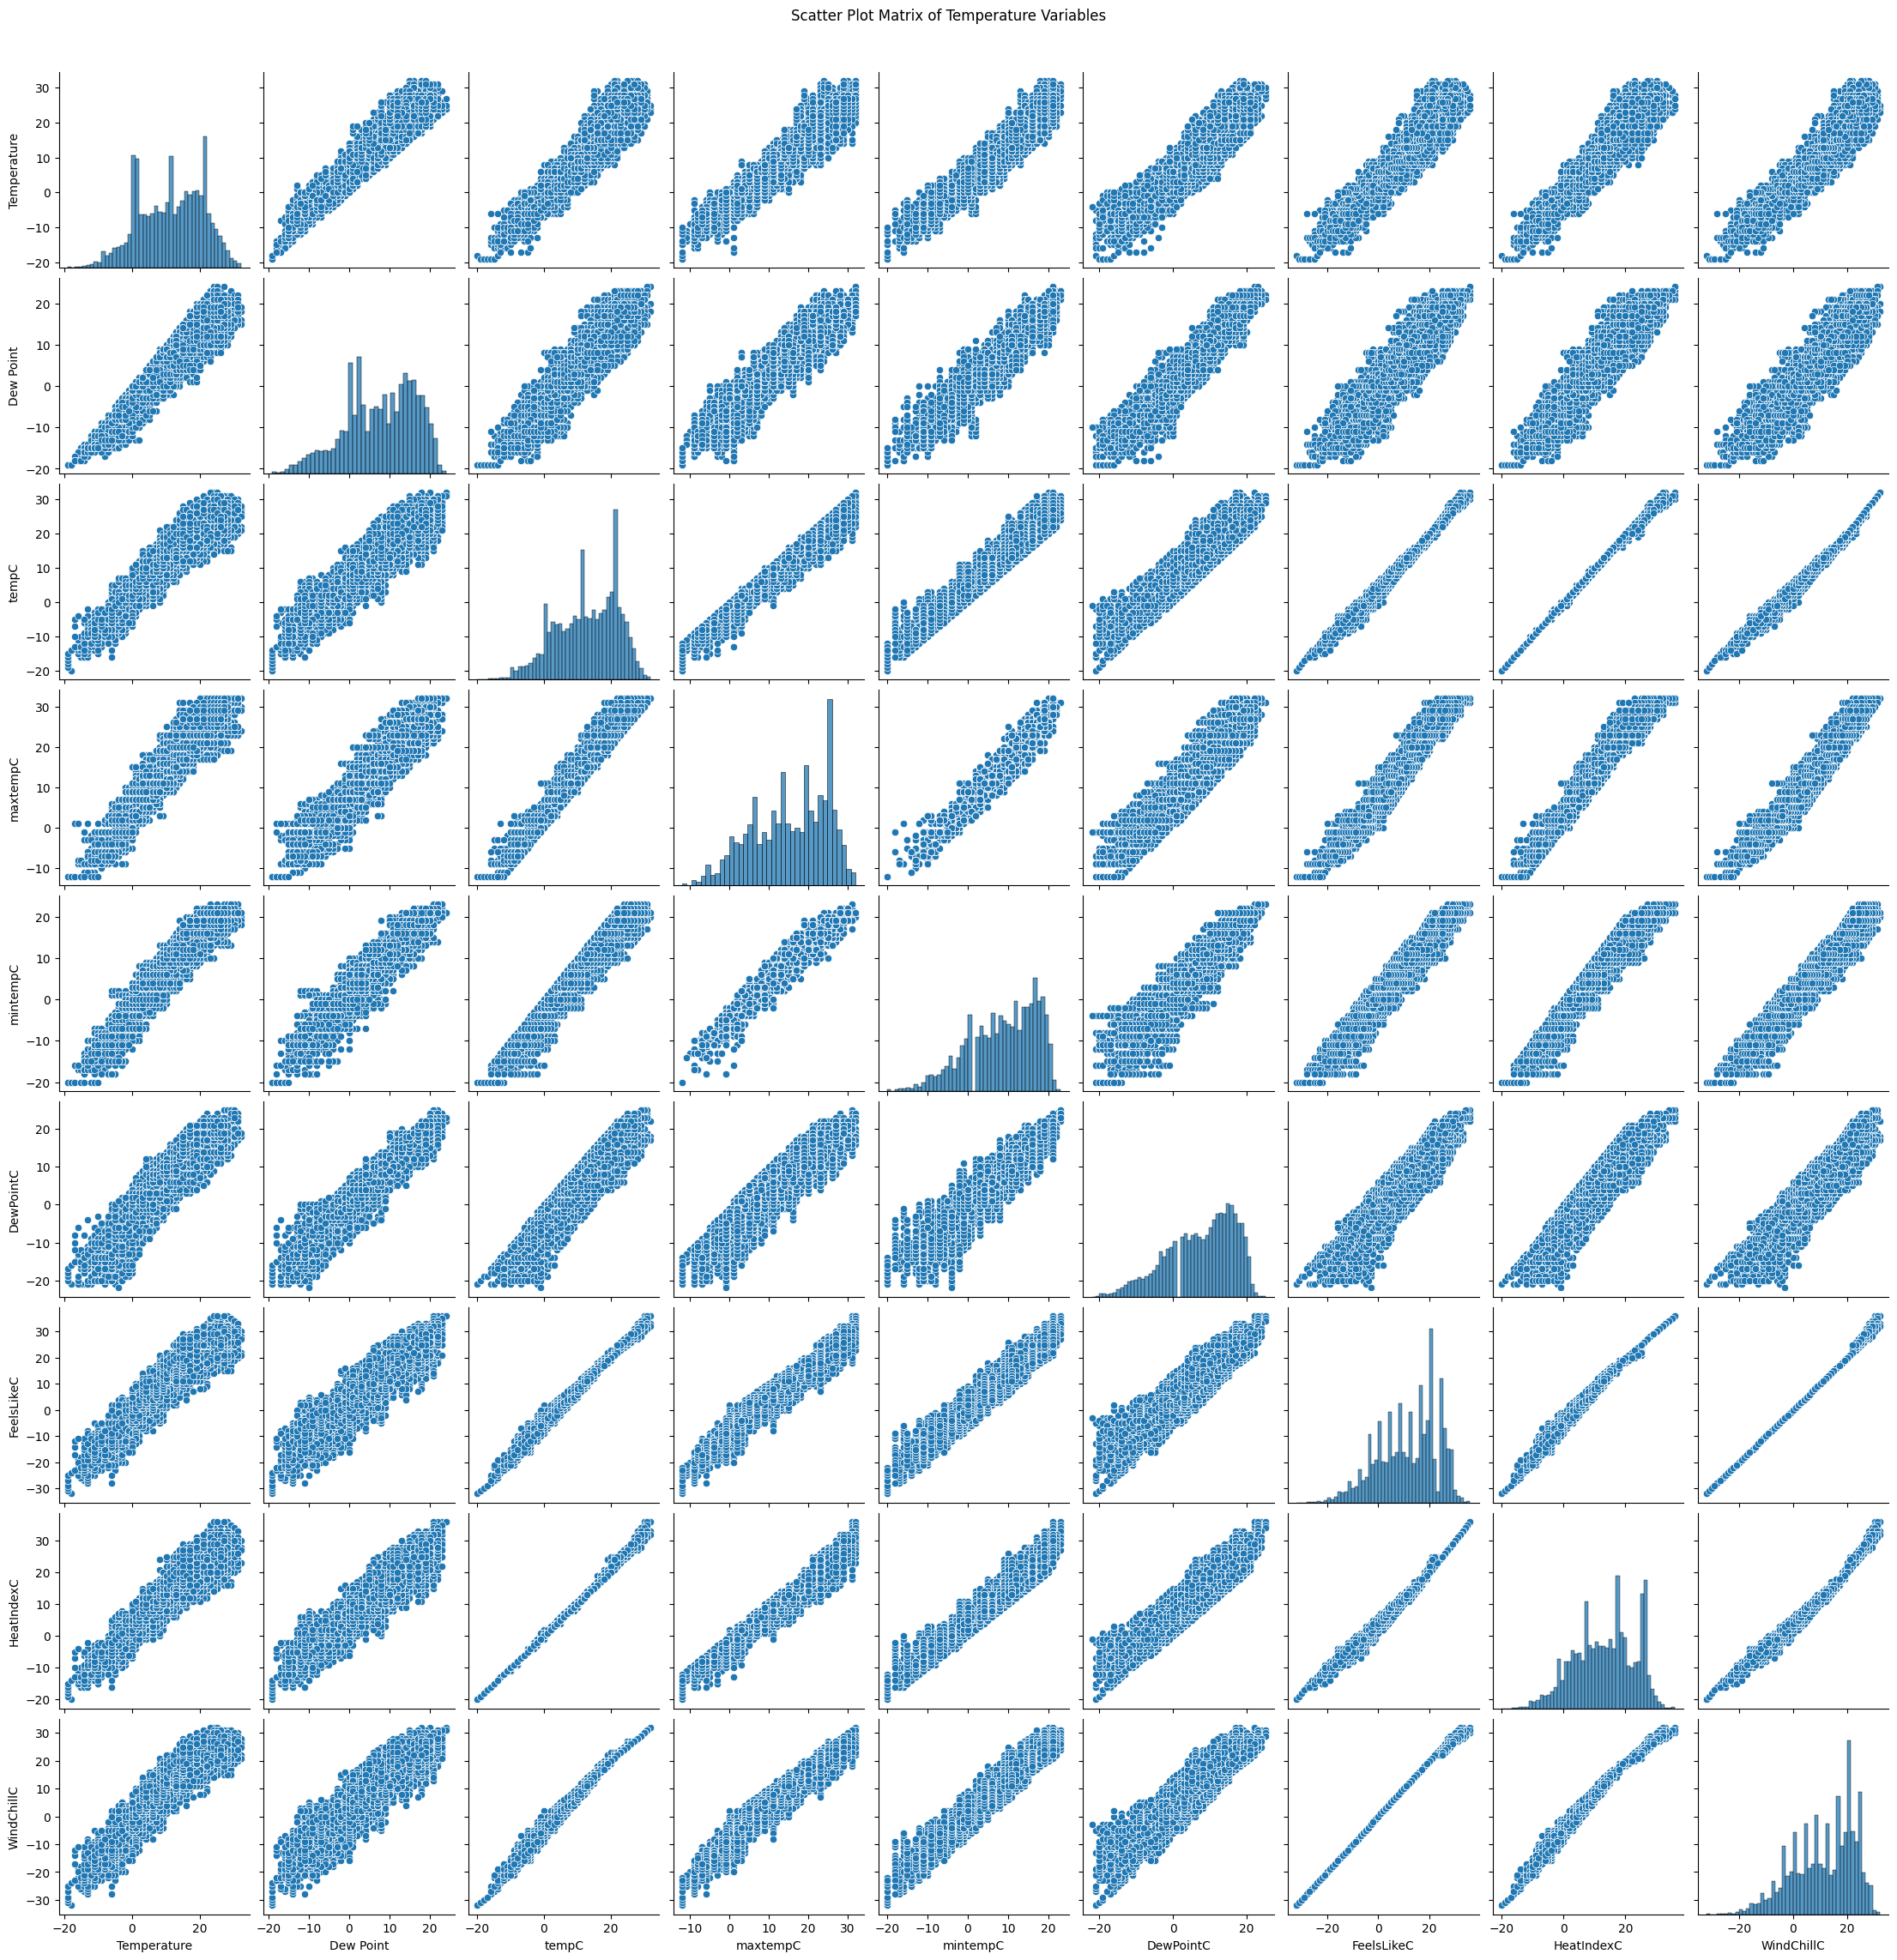

In [77]:
# Select the columns to analyze
columns_for_analysis = [
    'Temperature',
    'Dew Point',
    'tempC',      
    'maxtempC',   
    'mintempC',   
    'DewPointC',  
    'FeelsLikeC', 
    'HeatIndexC', 
    'WindChillC'  
]

# Plot the scatter plot matrix
sns.pairplot(data2_1[columns_for_analysis])
plt.suptitle("Scatter Plot Matrix of Temperature Variables", y=1.02)
plt.show()

In [78]:
# Standardize the data before applying PCA
scaler = StandardScaler()
temperature_data_scaled = scaler.fit_transform(data2_1[temperature_related_columns])

# Perform PCA
pca = PCA(n_components=None)
pca.fit(temperature_data_scaled)

# Transform the data into principal components
temperature_pca = pca.transform(temperature_data_scaled)

# Create a DataFrame to store the principal components
temperature_pca_df = pd.DataFrame(data=temperature_pca, 
                                  columns=[f'PC{i+1}' for i in range(temperature_pca.shape[1])])

# Explained variance
explained_variance = pca.explained_variance_ratio_

# Print explained variance for each component
for i, var in enumerate(explained_variance):
    print(f'Principal Component {i+1}: {var:.4f} variance explained')

# Calculate and print the loadings (eigenvectors)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Create a DataFrame for the loadings
loadings_df = pd.DataFrame(loadings, 
                           columns=[f'PC{i+1}' for i in range(temperature_pca.shape[1])], 
                           index=temperature_related_columns)

# Print the loadings for each component
print("\nPCA Loadings:")
print(loadings_df)

Principal Component 1: 0.9570 variance explained
Principal Component 2: 0.0180 variance explained
Principal Component 3: 0.0110 variance explained
Principal Component 4: 0.0055 variance explained
Principal Component 5: 0.0037 variance explained
Principal Component 6: 0.0033 variance explained
Principal Component 7: 0.0011 variance explained
Principal Component 8: 0.0003 variance explained
Principal Component 9: 0.0001 variance explained

PCA Loadings:
                  PC1       PC2       PC3       PC4       PC5       PC6  \
Temperature  0.955760  0.091462  0.270610 -0.069558 -0.007218 -0.009313   
Dew Point    0.964858  0.219512 -0.063763  0.026273 -0.060316  0.111463   
tempC        0.990345 -0.122662 -0.026185 -0.024462 -0.025083  0.011494   
maxtempC     0.982441 -0.050226  0.034251  0.091189  0.142485  0.050442   
mintempC     0.979783  0.071377  0.008891  0.152339 -0.049110 -0.096025   
DewPointC    0.963986  0.184693 -0.130635 -0.100411  0.068866 -0.068862   
FeelsLikeC   0.9893

In the analysis, the temperature-related variables were consolidated into a single composite index, the General Temperature Index (PC1). This index captures 95.82% of the variance in the original temperature data, effectively summarizing the overall temperature conditions as reflected by actual temperature, perceived temperature, and dew point. This approach allows for a more streamlined and interpretable analysis while retaining the critical information carried by the original variables.

In [79]:
# Drop the original temperature-related variables
data2_2 = data2_1.drop(columns=temperature_related_columns)

# Match the index
temperature_pca_df.index = data2_2.index

# Add the General Temperature Index (PC1) to the original dataframe
data2_2['General Temperature Index'] = temperature_pca_df['PC1']

print(data2_2.columns)

Index(['totalSnow_cm', 'sunHour', 'uvIndex', 'moon_illumination',
       'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure',
       'visibility', 'winddirDegree', 'windspeedKmph', 'DHI', 'DNI', 'GHI',
       'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Solar Zenith Angle',
       'Surface Albedo', 'Wind Speed', 'Relative Humidity', 'Pressure',
       '% Baseline', 'General Temperature Index'],
      dtype='object')


For test data

In [80]:
# Standardize the data before applying PCA
scaler = StandardScaler()
temperature_data_scaled = scaler.fit_transform(test2_1[temperature_related_columns])

# Perform PCA
pca = PCA(n_components=None)
pca.fit(temperature_data_scaled)

# Transform the data into principal components
temperature_pca = pca.transform(temperature_data_scaled)

# Create a DataFrame to store the principal components
temperature_pca_df = pd.DataFrame(data=temperature_pca, 
                                  columns=[f'PC{i+1}' for i in range(temperature_pca.shape[1])])

# Drop the original temperature-related variables
test2_2 = test2_1.drop(columns=temperature_related_columns)

# Match the index
temperature_pca_df.index = test2_2.index

# Add the General Temperature Index (PC1) to the original dataframe
test2_2['General Temperature Index'] = temperature_pca_df['PC1'].copy()

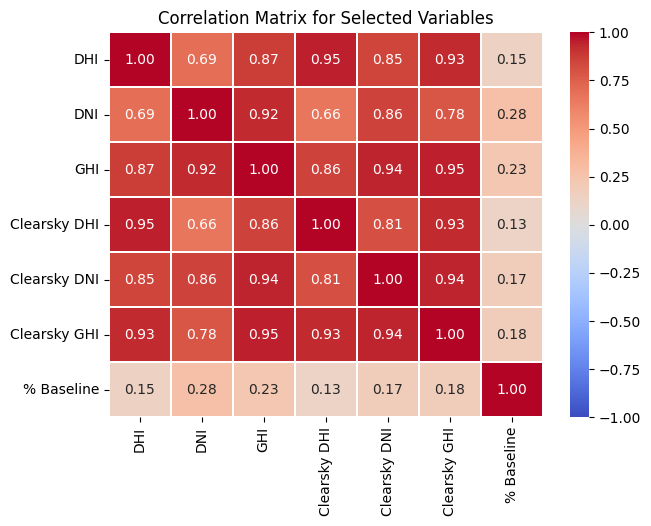

In [81]:
# Selecting the relevant variables for the new correlation matrix
solar_irradiance_columns = [
    'DHI', 'DNI', 'GHI',
    'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI'
]

# Calculating the correlation matrix for the selected variables
correlation_matrix = data2_1[solar_irradiance_columns + ['% Baseline']].corr(method='spearman')

# Plotting the correlation matrix
plt.figure(figsize=(7, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.1, vmin=-1, vmax=1)
plt.title('Correlation Matrix for Selected Variables')
plt.show()

The variables DHI, DNI, GHI, their clearsky counterparts, Solar Zenith Angle, and Relative Humidity exhibit high correlations with one another. This relationship will be further analyzed to understand their interactions.

In [82]:
# Standardize the data before applying PCA
scaler = StandardScaler()
solar_data_scaled = scaler.fit_transform(data2_2[solar_irradiance_columns])

# Perform PCA
pca = PCA(n_components=None)
pca.fit(solar_data_scaled)

# Transform the data into principal components
solar_pca = pca.transform(solar_data_scaled)

# Create a DataFrame to store the principal components
solar_pca_df = pd.DataFrame(data=solar_pca, 
                      columns=[f'PC{i+1}' for i in range(solar_pca.shape[1])])

# Explained variance
explained_variance = pca.explained_variance_ratio_

# Print explained variance for each component
for i, var in enumerate(explained_variance):
    print(f'Principal Component {i+1}: {var:.4f} variance explained')

# Calculate and print the loadings (eigenvectors)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Create a DataFrame for the loadings
loadings_df = pd.DataFrame(loadings, 
                           columns=[f'PC{i+1}' for i in range(solar_pca.shape[1])], 
                           index=solar_irradiance_columns)

print("\nPCA Loadings:")
print(loadings_df)

Principal Component 1: 0.7841 variance explained
Principal Component 2: 0.1511 variance explained
Principal Component 3: 0.0312 variance explained
Principal Component 4: 0.0196 variance explained
Principal Component 5: 0.0127 variance explained
Principal Component 6: 0.0013 variance explained

PCA Loadings:
                   PC1       PC2       PC3       PC4       PC5       PC6
DHI           0.809292 -0.515162 -0.250001  0.047606 -0.121531 -0.013061
DNI           0.730896  0.669383  0.005581 -0.007768 -0.127624 -0.037289
GHI           0.928579  0.281713 -0.183281 -0.133908  0.065139  0.051626
Clearsky DHI  0.888492 -0.319500  0.271814 -0.172264 -0.070226  0.008101
Clearsky DNI  0.954875  0.046213  0.131562  0.260190  0.008376  0.032450
Clearsky GHI  0.975761 -0.096520  0.001339 -0.003996  0.190154 -0.049497


Given the complexity and uncertainty in interpreting the reduced components through PCA, and considering the importance of preserving the full context of each variable, the decision was made to retain all original variables in the descriptive analysis. This approach ensures that the richness of the data is fully captured, allowing for a more nuanced understanding of the relationships between variables. By maintaining the integrity of the dataset, any subtle interactions or unique contributions of individual variables are preserved, providing a clearer and more comprehensive insight into the underlying patterns. This decision also avoids potential oversimplification that could arise from combining variables with distinct physical meanings or implications.

Given the presence of numerous temperature-related variables in the dataset, and their high correlations with each other, the next step is to implement strategies for reducing redundancy. This will ensure that only the most informative and distinct variables are retained for further analysis.

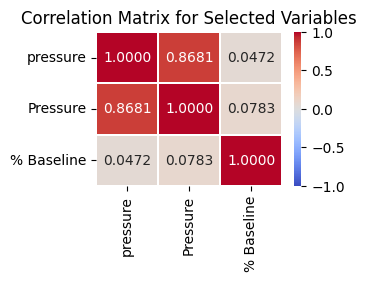

In [83]:
pressure_columns = ['pressure', 'Pressure']

# Calculating the correlation matrix for the for pressure variables with Baseline
correlation_matrix = data2_1[pressure_columns + ['% Baseline']].corr(method='spearman')

# Plotting the correlation matrix
plt.figure(figsize=(3, 2))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".4f", linewidths=.1, vmin=-1, vmax=1)
plt.title('Correlation Matrix for Selected Variables')
plt.show()

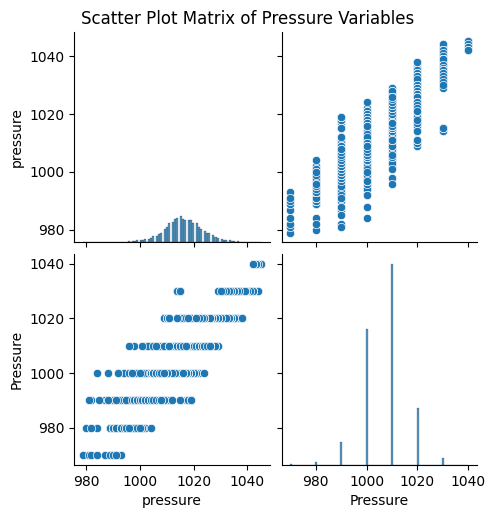

In [84]:
# Plot the scatter plot matrix
sns.pairplot(data2_2[pressure_columns])
plt.suptitle("Scatter Plot Matrix of Pressure Variables", y=1.02)
plt.show()

In [85]:
# Standardize the data before applying PCA
scaler = StandardScaler()
pressure_data_scaled = scaler.fit_transform(data2_2[pressure_columns])

# Perform PCA
pca = PCA(n_components=None)  # Keep all components initially
pca.fit(pressure_data_scaled)

# Transform the data into principal components
pressure_pca = pca.transform(pressure_data_scaled)

# Create a DataFrame to store the principal components
pressure_pca_df = pd.DataFrame(data=pressure_pca, 
                      columns=[f'PC{i+1}' for i in range(pressure_pca.shape[1])])

# Explained variance
explained_variance = pca.explained_variance_ratio_

# Print explained variance for each component
for i, var in enumerate(explained_variance):
    print(f'Principal Component {i+1}: {var:.4f} variance explained')

# Calculate and print the loadings (eigenvectors)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Create a DataFrame for the loadings
loadings_df = pd.DataFrame(loadings, 
                           columns=[f'PC{i+1}' for i in range(pressure_pca.shape[1])], 
                           index=pressure_columns)

# Print the loadings for each component
print("\nPCA Loadings:")
print(loadings_df)

Principal Component 1: 0.9414 variance explained
Principal Component 2: 0.0586 variance explained

PCA Loadings:
               PC1       PC2
pressure  0.970303  0.242003
Pressure  0.970303 -0.242003


The two pressure variables are nearly identical in their contribution to the first principal component, which explains 94.16% of the variance. This indicates they capture the same information. To reduce redundancy and simplify the dataset, these highly correlated variables will be combined into a single composite variable, retaining essential information while minimizing complexity.

In [86]:
data2_3 = data2_2.drop(pressure_columns, axis=1)

# Match the index
pressure_pca_df.index = data2_3.index

data2_3['Pressure Index'] = pressure_pca_df['PC1']
print(data2_3.columns)

Index(['totalSnow_cm', 'sunHour', 'uvIndex', 'moon_illumination',
       'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'visibility',
       'winddirDegree', 'windspeedKmph', 'DHI', 'DNI', 'GHI', 'Clearsky DHI',
       'Clearsky DNI', 'Clearsky GHI', 'Solar Zenith Angle', 'Surface Albedo',
       'Wind Speed', 'Relative Humidity', '% Baseline',
       'General Temperature Index', 'Pressure Index'],
      dtype='object')


For test data

In [87]:
# Standardize the data before applying PCA
scaler = StandardScaler()
pressure_data_scaled = scaler.fit_transform(test2_2[pressure_columns])

# Perform PCA
pca = PCA(n_components=None)  # Keep all components initially
pca.fit(pressure_data_scaled)

# Transform the data into principal components
pressure_pca = pca.transform(pressure_data_scaled)


# Create a DataFrame to store the principal components
pressure_pca_df = pd.DataFrame(data=pressure_pca, 
                      columns=[f'PC{i+1}' for i in range(pressure_pca.shape[1])])

test2_3 = test2_2.drop(pressure_columns, axis=1)

# Match the index
pressure_pca_df.index = test2_3.index

test2_3['Pressure Index'] = pressure_pca_df['PC1']

Now addressing wind-related variables: WindGustKmph, windspeedKmph, and Wind Speed, as they appear to be highly correlated with each other.

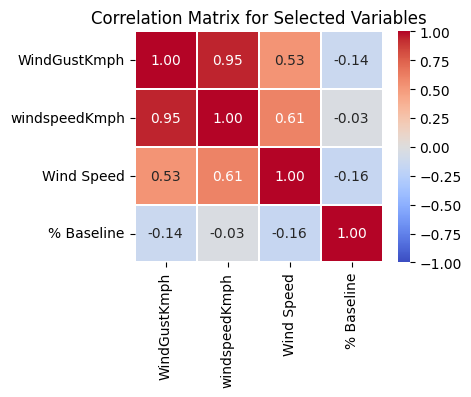

In [88]:
# Selecting the relevant variables for the new correlation matrix
wind_speed_columns = ['WindGustKmph', 'windspeedKmph', 'Wind Speed']

# Calculating the correlation matrix for the selected variables
correlation_matrix = data2_1[wind_speed_columns + ['% Baseline']].corr(method='spearman')

# Plotting the correlation matrix
plt.figure(figsize=(4, 3))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.1, vmin=-1, vmax=1)
plt.title('Correlation Matrix for Selected Variables')
plt.show()

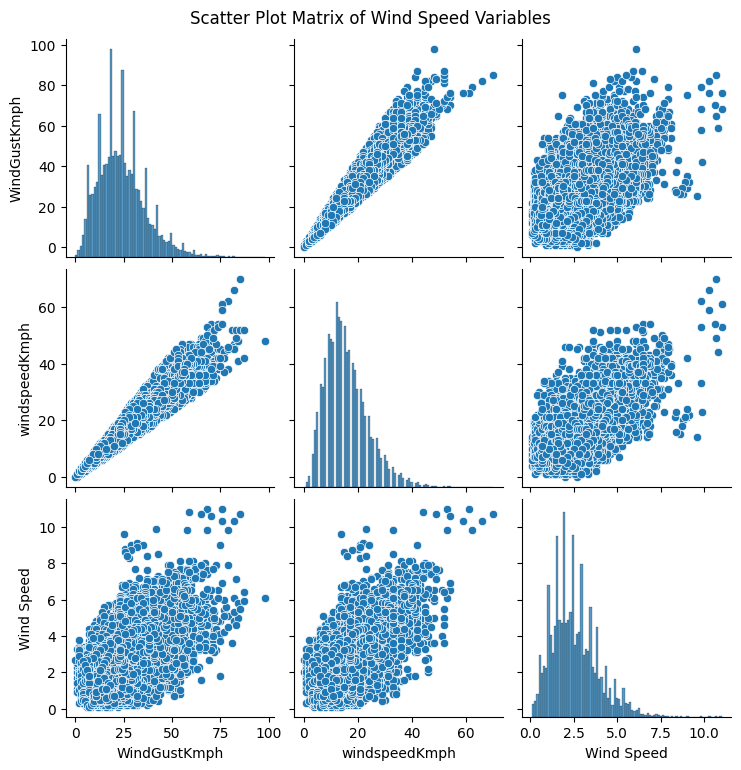

In [89]:
# Plot the scatter plot matrix
sns.pairplot(data2_3[wind_speed_columns])
plt.suptitle("Scatter Plot Matrix of Wind Speed Variables", y=1.02)
plt.show()

In [90]:
# Standardize the data before applying PCA
scaler = StandardScaler()
wind_data_scaled = scaler.fit_transform(data2_3[wind_speed_columns])

# Perform PCA
pca = PCA(n_components=None)  # Keep all components initially
pca.fit(wind_data_scaled)

# Transform the data into principal components
wind_pca = pca.transform(wind_data_scaled)

# Create a DataFrame to store the principal components
wind_pca_df = pd.DataFrame(data=wind_pca, 
                      columns=[f'PC{i+1}' for i in range(wind_pca.shape[1])])

# Explained variance
explained_variance = pca.explained_variance_ratio_

# Print explained variance for each component
for i, var in enumerate(explained_variance):
    print(f'Principal Component {i+1}: {var:.4f} variance explained')

# Calculate and print the loadings (eigenvectors)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Create a DataFrame for the loadings
loadings_df = pd.DataFrame(loadings, 
                           columns=[f'PC{i+1}' for i in range(wind_pca.shape[1])], 
                           index=wind_speed_columns)

# Print the loadings for each component
print("\nPCA Loadings:")
print(loadings_df)

Principal Component 1: 0.8189 variance explained
Principal Component 2: 0.1634 variance explained
Principal Component 3: 0.0177 variance explained

PCA Loadings:
                    PC1       PC2       PC3
WindGustKmph   0.937084 -0.313859 -0.153032
windspeedKmph  0.966851 -0.190605  0.170061
Wind Speed     0.802475  0.596154 -0.026194


Given that the first principal component (PC1) explains 83.09% of the variance and has strong loadings from all three wind-related variables (WindGustKmph, windspeedKmph, and Wind Speed), it effectively captures the overall wind intensity. To reduce redundancy and simplify the analysis, these variables will be combined into a single composite variable using PC1, which retains the essential information while minimizing complexity in the dataset.

In [91]:
data2_4 = data2_3.drop(wind_speed_columns, axis=1)

# Match the index
wind_pca_df.index = data2_4.index

data2_4['Wind Speed Index'] = wind_pca_df['PC1']
print(data2_4.columns)

Index(['totalSnow_cm', 'sunHour', 'uvIndex', 'moon_illumination', 'cloudcover',
       'humidity', 'precipMM', 'visibility', 'winddirDegree', 'DHI', 'DNI',
       'GHI', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI',
       'Solar Zenith Angle', 'Surface Albedo', 'Relative Humidity',
       '% Baseline', 'General Temperature Index', 'Pressure Index',
       'Wind Speed Index'],
      dtype='object')


For test data

In [92]:
# Standardize the data before applying PCA
scaler = StandardScaler()
wind_data_scaled = scaler.fit_transform(test2_3[wind_speed_columns])

# Perform PCA
pca = PCA(n_components=None)  # Keep all components initially
pca.fit(wind_data_scaled)

# Transform the data into principal components
wind_pca = pca.transform(wind_data_scaled)

# Create a DataFrame to store the principal components
wind_pca_df = pd.DataFrame(data=wind_pca, 
                      columns=[f'PC{i+1}' for i in range(wind_pca.shape[1])])

test2_4 = test2_3.drop(wind_speed_columns, axis=1)

# Match the index
wind_pca_df.index = test2_4.index

test2_4['Wind Speed Index'] = wind_pca_df['PC1']
print(test2_4.columns)

Index(['totalSnow_cm', 'sunHour', 'uvIndex', 'moon_illumination', 'cloudcover',
       'humidity', 'precipMM', 'visibility', 'winddirDegree', 'DHI', 'DNI',
       'GHI', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI',
       'Solar Zenith Angle', 'Surface Albedo', 'Relative Humidity',
       '% Baseline', 'General Temperature Index', 'Pressure Index',
       'Wind Speed Index'],
      dtype='object')


In [93]:
# Adding back 'Cloud Type'
data2_4['Cloud Type'] = data2['Cloud Type'].copy()
test2_4['Cloud Type'] = test2['Cloud Type'].copy()

# Adding back 'Timestamp'
data2_4['Timestamp'] = data2['Timestamp'].copy()
test2_4['Timestamp'] = test2['Timestamp'].copy()

In [94]:
# Checking existence of missing data
missing_data = data2_4.isnull().sum()
columns_with_missing = missing_data[missing_data > 0]
print(columns_with_missing)

# Checking existence of missing data
missing_data = test2_4.isnull().sum()
columns_with_missing = missing_data[missing_data > 0]
print(columns_with_missing)

Cloud Type    1141
dtype: int64
% Baseline    2208
dtype: int64


In [95]:
# Move the '% Baseline' column to the last position
data2_4 = data2_4[[col for col in data2_4.columns if col != '% Baseline'] + ['% Baseline']]
test2_4 = test2_4[[col for col in test2_4.columns if col != '% Baseline'] + ['% Baseline']]

# Export dataset without irrelevant columns
data2_4.to_excel(r"Processed Data\train_reduced_data.xlsx", index=False)
test2_4.to_excel(r"Processed Data\test_reduced_data.xlsx", index=False)

# Predictive Model

## Data reading and final processing

In [96]:
# Read preprocessed data
train = pd.read_excel(r"Processed Data\train_reduced_data.xlsx")
test = pd.read_excel(r"Processed Data\test_reduced_data.xlsx")
submis = pd.read_csv(r"Raw Data\dataset\test.csv")

In [97]:
# Label encoding to 'Cloud Type'
label_encoder = LabelEncoder()

train['Cloud Type'] = label_encoder.fit_transform(train['Cloud Type'])
train['Cloud Type'] = train['Cloud Type'].astype('category')
test['Cloud Type'] = label_encoder.fit_transform(test['Cloud Type'])
test['Cloud Type'] = test['Cloud Type'].astype('category')

# Verify the data type
print(train['Cloud Type'].dtype) 
print(test['Cloud Type'].dtype) 

category
category


In [98]:
# Backup original timestamp for submission file
time_ori = submis['Timestamp'].copy()

# Datetime formatting to match with test data
submis['Timestamp'] = pd.to_datetime(submis['Timestamp'], format='%b %d, %Y %I%p')

# Sort by date to ensure correct prediction order
submis = submis.sort_values(by='Timestamp', ascending=True)
test = test.sort_values(by='Timestamp', ascending=True)

# Keeping only data with the same timestamp as the one in submission file
test = test[test['Timestamp'].isin(submis['Timestamp'])]

print(submis.head())

            Timestamp  % Baseline
0 2017-10-01 06:00:00         NaN
1 2017-10-01 07:00:00         NaN
2 2017-10-01 08:00:00         NaN
3 2017-10-01 09:00:00         NaN
4 2017-10-01 10:00:00         NaN


In [99]:
X = train.drop(columns=["% Baseline", 'Timestamp'])
y = train["% Baseline"]

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Random Forest

In [100]:
# Define RMSE scoring
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Define the model
rf_model = RandomForestRegressor(random_state=42)

# Define the parameter grid for RandomizedSearchCV
param_distributions = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(4, 20),  
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10), 
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_distributions,
    n_iter=200,
    cv=5,
    verbose=3,
    random_state=42,
    error_score='raise',
    scoring=rmse_scorer,
    n_jobs=-1
)

# Fit the model to find the best parameters
random_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters: ", random_search.best_params_)
print("Best Score: ", random_search.best_score_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best Parameters:  {'bootstrap': False, 'max_depth': 17, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 162}
Best Score:  -0.11710199443108718


In [101]:
# Initialize the RandomForestRegressor with the best parameters
best_rf_model = RandomForestRegressor(
    n_estimators=162,
    max_depth=17,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=False,
    random_state=42
)

# Fit the model on the training dataset
best_rf_model.fit(X_train, y_train)

# Evaluating model
y_pred = best_rf_model.predict(X_test)
rmse_value = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE: ", rmse_value)

Test RMSE:  0.1111114499955574


In [102]:
feature_importances = pd.Series(best_rf_model.feature_importances_, index=X.columns)
sorted_importances = feature_importances.sort_values(ascending=False)

# Print sorted feature importances
print(sorted_importances)

humidity                     0.247774
Solar Zenith Angle           0.153721
sunHour                      0.084071
Relative Humidity            0.055250
cloudcover                   0.054685
DNI                          0.047217
Clearsky GHI                 0.044431
General Temperature Index    0.040576
Surface Albedo               0.032457
Clearsky DNI                 0.031031
winddirDegree                0.030330
DHI                          0.030217
GHI                          0.028465
Clearsky DHI                 0.027319
Wind Speed Index             0.019435
Pressure Index               0.017184
uvIndex                      0.015779
moon_illumination            0.014277
Cloud Type                   0.011230
visibility                   0.007948
precipMM                     0.004439
totalSnow_cm                 0.002165
dtype: float64


In [103]:
predictions = best_rf_model.predict(test.drop(['% Baseline', 'Timestamp'], axis=1))

In [104]:
submis = pd.DataFrame({
    'Timestamp': time_ori,
    '% Baseline': predictions
})

# Display the DataFrame
print(submis.head())

          Timestamp  % Baseline
0   Oct 1, 2017 6am    0.076580
1   Oct 1, 2017 7am    0.062287
2   Oct 1, 2017 8am    0.132892
3   Oct 1, 2017 9am    0.301760
4  Oct 1, 2017 10am    0.490597


# Plot Prediction Result

In [105]:
baseline = pd.read_excel(r"Processed Data\Baseline Value.xlsx")
print(baseline)

                Timestamp  % Baseline
0     2014-01-01 07:00:00    0.007900
1     2014-01-01 08:00:00    0.101900
2     2014-01-01 09:00:00    0.393200
3     2014-01-01 10:00:00    0.544700
4     2014-01-01 11:00:00    0.548500
...                   ...         ...
20014 2017-12-31 12:00:00    0.502420
20015 2017-12-31 13:00:00    0.346326
20016 2017-12-31 14:00:00    0.428973
20017 2017-12-31 15:00:00    0.335771
20018 2017-12-31 16:00:00    0.221570

[20019 rows x 2 columns]


In [106]:
# Set 'Timestamp' as the index
baseline.set_index('Timestamp', inplace=True)

# Resample the data to 7-day intervals and calculate the mean
baseline_7day_mean = baseline.resample('7D').mean()

# Reset index if needed
baseline_7day_mean.reset_index(inplace=True)

# Display the aggregated data
print(baseline_7day_mean)

     Timestamp  % Baseline
0   2014-01-01    0.146517
1   2014-01-08    0.156907
2   2014-01-15    0.148056
3   2014-01-22    0.121972
4   2014-01-29    0.129651
..         ...         ...
204 2017-11-29    0.157853
205 2017-12-06    0.160042
206 2017-12-13    0.193436
207 2017-12-20    0.178840
208 2017-12-27    0.197071

[209 rows x 2 columns]
